# SCORE Sports Data Repository Questions
## WNBA Shot Chart Classification

### Motivation

The Women’s National Basketball Association (WNBA) is the top professional women’s basketball league in the world. The league records every shot players take along with contextual information about the shot such as its location, a description of the shot type, as well as the outcome.

With this dataset, you can predict the success of each shot attempt to compute the expected value of shot types and compare team decision making.

### Questions

1. Create a visualization displaying the joint frequency of shot locations.

2. Perform a similar analysis by team

3. Perform a similar analysis by shot type

4. Build a classification model to predict the shot outcome based on the spatial x,y coordinates of the shot.

### Cleaning Data

In order to get the dataset ready for modeling, I will try to categorize as much of the detail as possible in the description of each shot.  This will include feature engineering specific aspects of the description in addition to numerical data.

Fortunately the description are fairly striaght forward and includes three types of descriptions:
- The movement of the player as they take the shot.  ie. 'Running', 'Driving', 'Step Back'
- The type of shot taken, ie. 'Dunk', 'Layup', 'Jump'
- And the style of the shot when it was taken, ie. 'Finger Roll', 'Bank'.

Using this we can take the description and separate these words in order to include the information into the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.interpolate import griddata

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss

pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('wnba-shots-2021.csv')

In [3]:
# Removing All-Star Game
df = df[df['game_id'] != 401455978].reset_index(drop = True)

In [4]:
# List of movements of the player shooting
movement_list = ['Running', 'Driving', 'Cutting', 'Turnaround', 'Alley Oop', 'Step Back', 'Fade Away', 'Pullup',
                'Floating', 'Reverse']

In [5]:
# List of shot types
shot_type_list = ['Dunk', 'Layup', 'Hook', 'Jump', 'Tip', 'Putback', 'Free Throw']

In [6]:
# List of styles
style_list = ['Finger Roll', 'Bank']

In [7]:
# Simple function in order to find each word within the description, 'None' if it is not found
def find_word(text, word_list):
    for word in word_list:
        if word in text:
            return word
    return 'None'

In [8]:
df['movement'] = df['shot_type'].apply(lambda x: find_word(x, movement_list))
df['type'] = df['shot_type'].apply(lambda x: find_word(x, shot_type_list))
df['style'] = df['shot_type'].apply(lambda x: find_word(x, style_list))

In [9]:
# Coordinates for Free Throws are odd, so correcting them to be accurate from where they took place on the court
df.loc[df['shot_type'].str.contains('Free'), 'coordinate_x'] = 25
df.loc[df['shot_type'].str.contains('Free'), 'coordinate_y'] = 19

In [10]:
# Adding the score differential as a numerical feature, as well as whether the shooter was at home
df['score_diff'] = abs(df['home_score'] - df['away_score'])
df['shooter_home'] = np.where(df['shooting_team'] == df['home_team_name'], 1, 0)

In [11]:
# Using pythagorean theorum to determine exact distance of shot
df['shot_dist'] = round(((df['coordinate_x']-25)**2 + (df['coordinate_y'])**2)**0.5, 1)

In [12]:
# Tracking the max_value of the shot in order to make eFG% calculations later
df['max_value'] = 2
df.loc[df['desc'].str.contains('three'), 'max_value'] = 3
df.loc[df['shot_type'].str.contains('Free'), 'max_value'] = 1

The description includes information about who shot the ball, but also who assisted on the shot (if there was someone) and who blocked the shot if it was blocked.  The following text parser function will be able to identify JUST the shooter of the ball.

In [13]:
def extract_shooter(description):
    words = re.findall(r'\b\w+\b', description)

    if 'blocks' in words:
        blocks_index = words.index('blocks')
        words = words[blocks_index + 1:]
    if 'assists' in words:
        assists_index = words.index('assists')
        words = words[0:assists_index-3]

    capitalized_words = [word for word in words if word.istitle()]
    return ' '.join(capitalized_words) if capitalized_words else None

In [14]:
df['shooter'] = df['desc'].apply(extract_shooter)

In [15]:
# Determining what team was defending the shot
def determine_defending_team(row):
    if row['shooting_team'] == row['home_team_name']:
        return row['away_team_name']
    else:
        return row['home_team_name']

In [16]:
df['defending_team'] = df.apply(determine_defending_team, axis=1)

In [17]:
# Organizing the dataframe and keeping the columns I want to use
df1 = df[['shooter', 'shooting_team', 'defending_team', 'shooter_home','qtr', 'quarter_seconds_remaining',
          'game_seconds_remaining', 'home_score', 'away_score', 'score_diff', 'coordinate_x', 'coordinate_y',
          'shot_value', 'max_value', 'movement', 'type', 'style', 'shot_dist', 'made_shot']]

df1.head()

,shooter,shooting_team,defending_team,shooter_home,qtr,quarter_seconds_remaining,game_seconds_remaining,home_score,away_score,score_diff,coordinate_x,coordinate_y,shot_value,max_value,movement,type,style,shot_dist,made_shot
0,Destanni Henderson,Indiana,Washington,0,1,571,2371,0,0,0,37,9,0,2,None,Jump,None,15.0,False
1,Elena Delle Donne,Washington,Indiana,1,1,551,2351,0,0,0,12,0,0,2,Turnaround,Jump,Bank,13.0,False
2,Tiffany Mitchell,Indiana,Washington,0,1,538,2338,0,2,2,29,2,2,2,Cutting,Layup,None,4.5,True
3,Natasha Cloud,Washington,Indiana,1,1,524,2324,2,2,0,22,0,2,2,Driving,Layup,None,3.0,True
4,Tiffany Mitchell,Indiana,Washington,0,1,512,2312,2,5,3,9,21,3,3,None,Jump,None,26.4,True


### Initial EDA

With the dataset re-organized and the shot descriptions parsed, I want to look at the data to get a sense of which type of shots are more likely to go in.

In [18]:
# Use to compare categories against the overall percentage of successful shots.
shot_average = df1['made_shot'].mean()

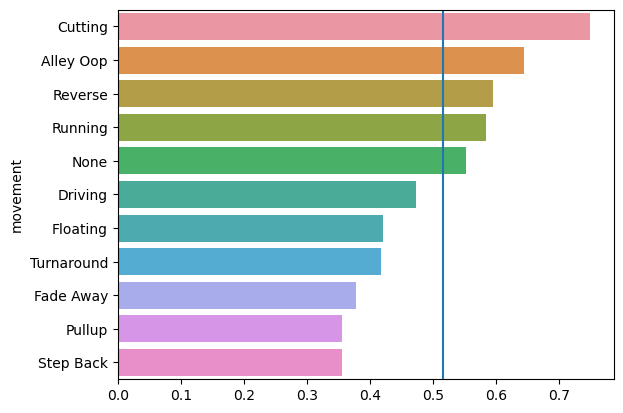

In [19]:
gb = df1.groupby('movement').mean(numeric_only = True)['made_shot'].sort_values(ascending = False)
sns.barplot(y = gb.index,
           x = gb.values)
plt.axvline(shot_average)
plt.show()

Cutting, Alley Oop, Reverse and Running shots all have greater shooting percentages than average.

Pullups are the worse compared to the average, with Step Backs and Fade Aways being almost as low.

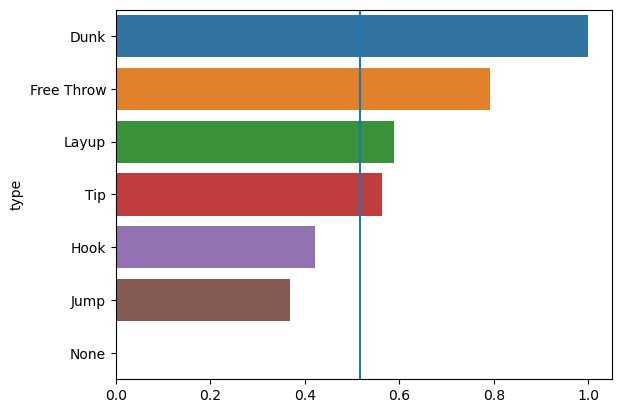

In [20]:
gb = df1.groupby('type').mean(numeric_only = True)['made_shot'].sort_values(ascending = False)
sns.barplot(y = gb.index,
           x = gb.values)
plt.axvline(shot_average)
plt.show()

Dunks are perfect, but there are only 3 in the entire dataset.

Layups and Tips, which both typically take place close to the basket, having better than average FG percentages.  A Regular Jump shot has the worse percentage, but would also encapsulate all long distance shots.

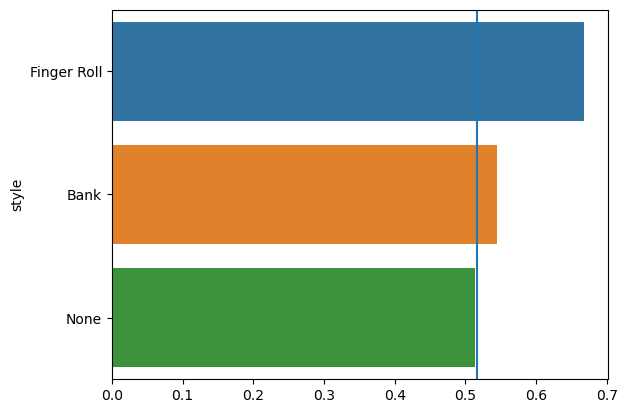

In [21]:
gb = df1.groupby('style').mean(numeric_only = True)['made_shot'].sort_values(ascending = False)
sns.barplot(y = gb.index,
           x = gb.values)
plt.axvline(shot_average)
plt.show()

Regular shots are barely below average, whereas Bank and Finger Rolls (which are typically layups) are both higher than average.

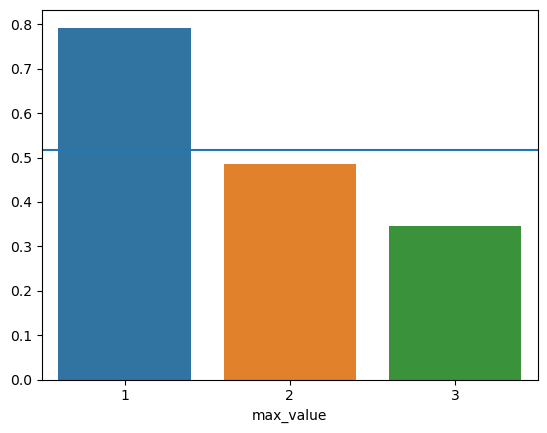

In [22]:
gb = df1.groupby('max_value').mean(numeric_only = True)['made_shot'].sort_values(ascending = False)
sns.barplot(x = gb.index,
           y = gb.values)
plt.axhline(shot_average)
plt.show()

Unsurprisingly, Free Throws have the best percentage, whereas 3-point shots have the worst.  When taking into account true shooting percentages for each location on the floor, it is clear that Free Throws should be removed as that spot on the floor may be inflated in quality as a result of the free throws.

### 1. Create a visualization displaying the joint frequency of shot locations.

To get a sense of what the shooting percentage looks like across the court, I'll remove the free throws and have a look at 3 things:

1. Where are shots being taken
2. Where are shots being made
3. What is the number of points made from each spot (Percentage of Shots Made * The Value of the Shot)

Here we will see what sort of patterns we can see across the league

In [23]:
mean_value = df1['shot_value'].mean()

In [24]:
total_shots_gb = df1[df1['max_value'] > 1].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()

total_shots_data = total_shots_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

In [25]:
made_shots_gb = df1[(df1['max_value'] > 1) & (df1['made_shot'] == True)].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()

made_shots_data = made_shots_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

In [26]:
# Setting Data up to get the expected points for each spot on the floor
result_df = df1.groupby(['coordinate_x', 'coordinate_y']).agg(
    total_made_shots=pd.NamedAgg(column='made_shot', aggfunc='sum'),
    total_shots=pd.NamedAgg(column='made_shot', aggfunc='count'),
    max_value=('max_value', 'first')
).reset_index()

# Removing spots where there was only 1 shot taken, typically extremely long distance shots that end a quarter
result_df.loc[result_df['total_shots'] <= 1, 'total_made_shots'] = 0

# Calculating the average number of points earned for each spot on the floor
result_df['result'] = (result_df['total_made_shots'] / result_df['total_shots']) * result_df['max_value']

result_df['mean_compare'] = result_df['result'] - mean_value

xp_data = result_df.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'mean_compare')

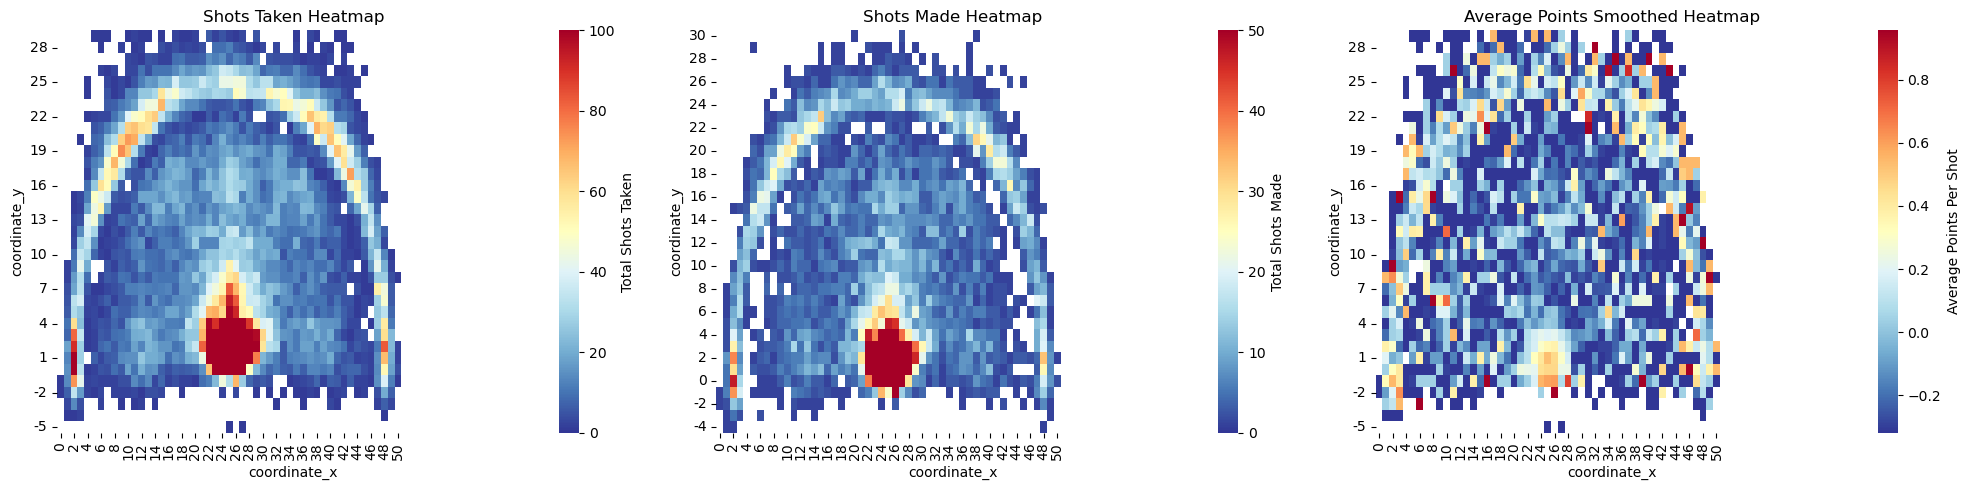

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Total Shots Taken Heatmap
sns.heatmap(total_shots_data, cmap='RdYlBu_r', vmin=0, vmax=100, cbar_kws={'label': 'Total Shots Taken'}, ax=axes[0])
axes[0].set_title('Shots Taken Heatmap')
axes[0].set_xlim(0, 70)
axes[0].set_ylim(0, 35)

# Plot 2: Shots Made Heatmap
sns.heatmap(made_shots_data, cmap='RdYlBu_r', vmin=0, vmax=50, cbar_kws={'label': 'Total Shots Made'}, ax=axes[1])
axes[1].set_title('Shots Made Heatmap')
axes[1].set_xlim(0, 70)
axes[1].set_ylim(0, 35)

# Plot 3: Average Points Smoothed Heatmap
sns.heatmap(xp_data, cmap='RdYlBu_r', vmin=-mean_value/3, vmax=mean_value, cbar_kws={'label': 'Average Points Per Shot'}, ax=axes[2])
axes[2].set_title('Average Points Smoothed Heatmap')
axes[2].set_xlim(0, 70)
axes[2].set_ylim(0, 35)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Some interesting patterns arise here. As it seems to be the trend in modern basketball, there are a lot of shots taken close to the basket and beyond the 3-point line.

Interestingly, there is a pattern of mid range shots being taken along the baseline, in the 'corners' of the key, and right by the free throw line.

While there's a higher frequency of shots taken right along the 3-point line, they seem to be more concentrated in the 'corners' (right by the baseline) and at the edge of the arc, as oppose to straight on.

The Made shots all follow these patterns as well, but the points earned at each spot is not quite as uniform.

The average number of points earned at a given spot on the court is .71 points per shot.
Most of the spots that earn more than that are still close to the hoop or at three point range. Interestingly, the corner three is not distinctively a hotter spot than other parts of the 3 point line.  As well, there seem to be spots in the mid range along the shape of the key that produce more value than other portions of the floor. 

### 2. Perform a similar analysis for each team

With the code set, I'll run it through for each team and see if there is any patterns or differentiation between teams.

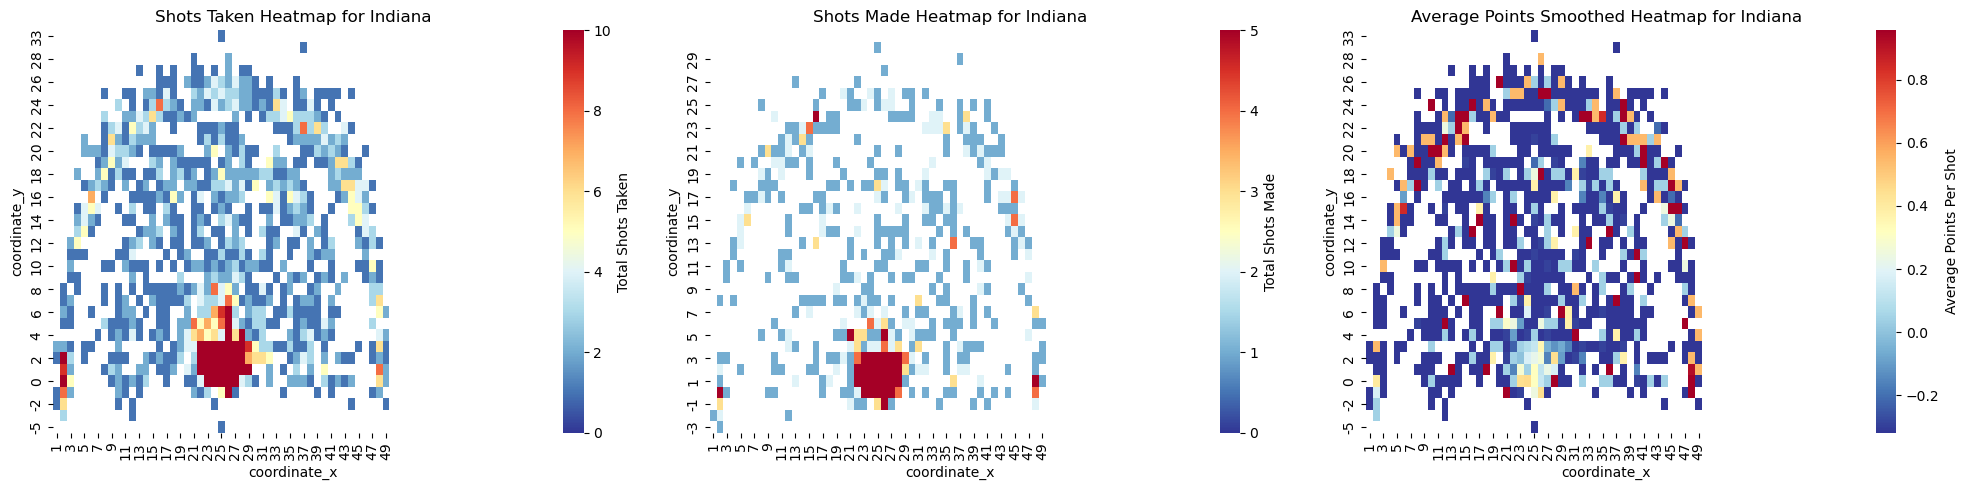

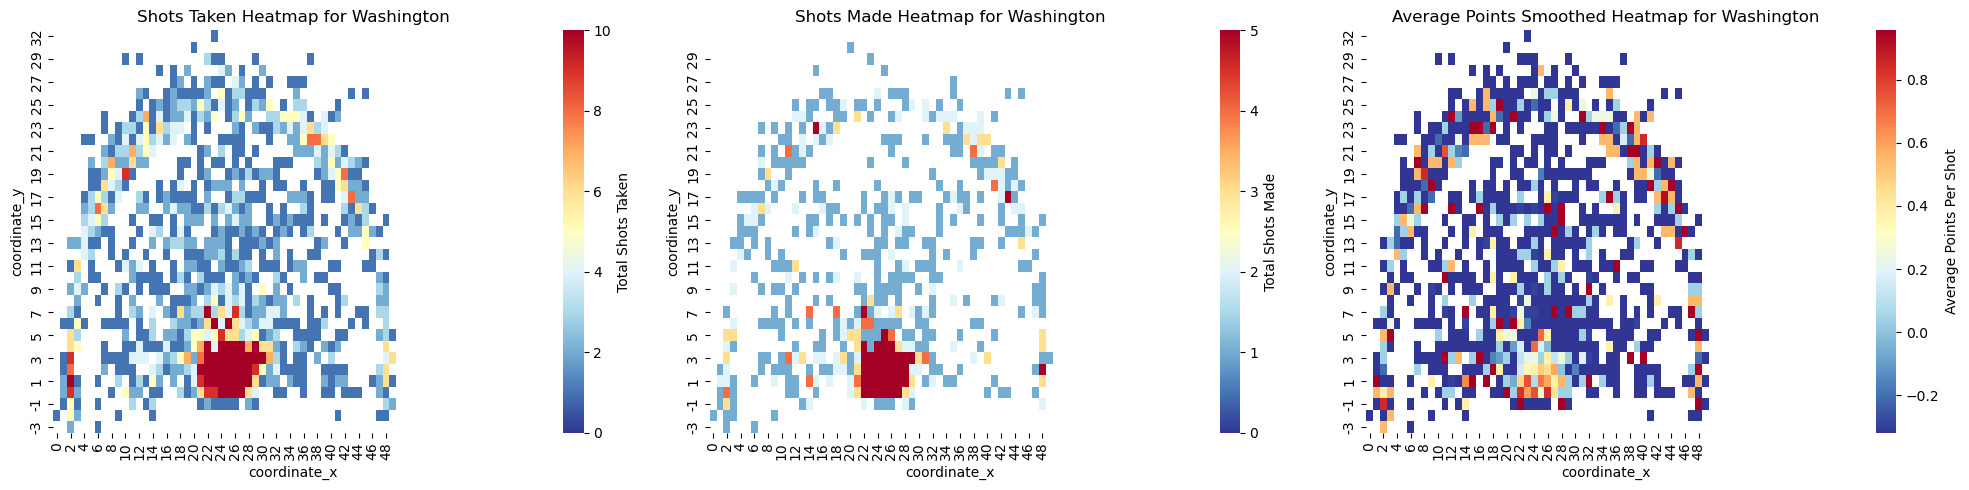

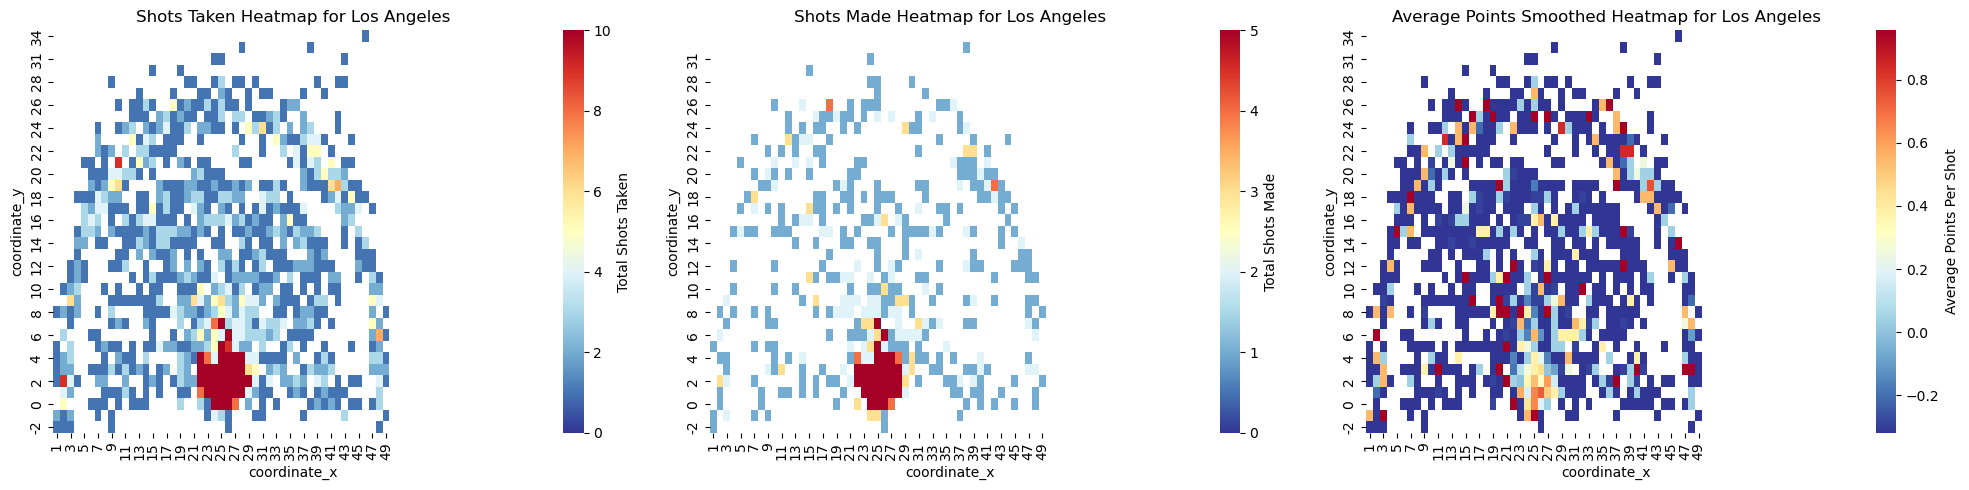

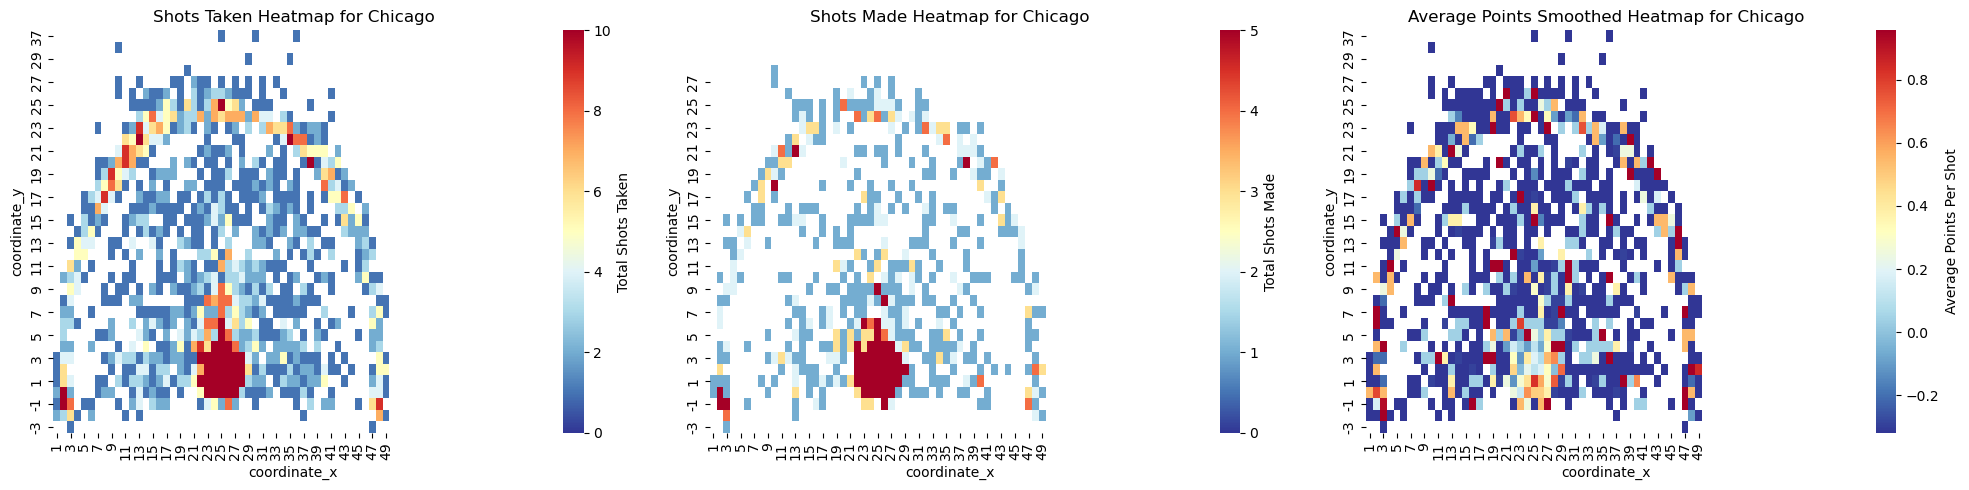

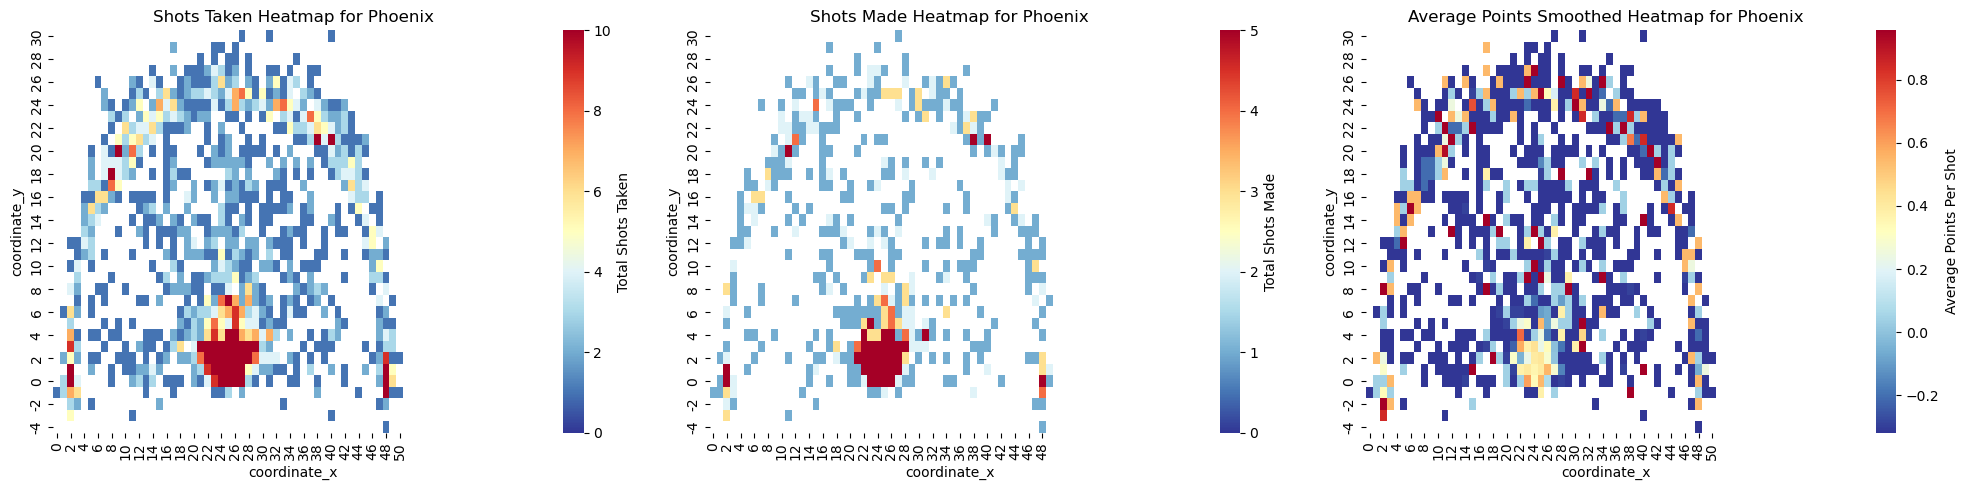

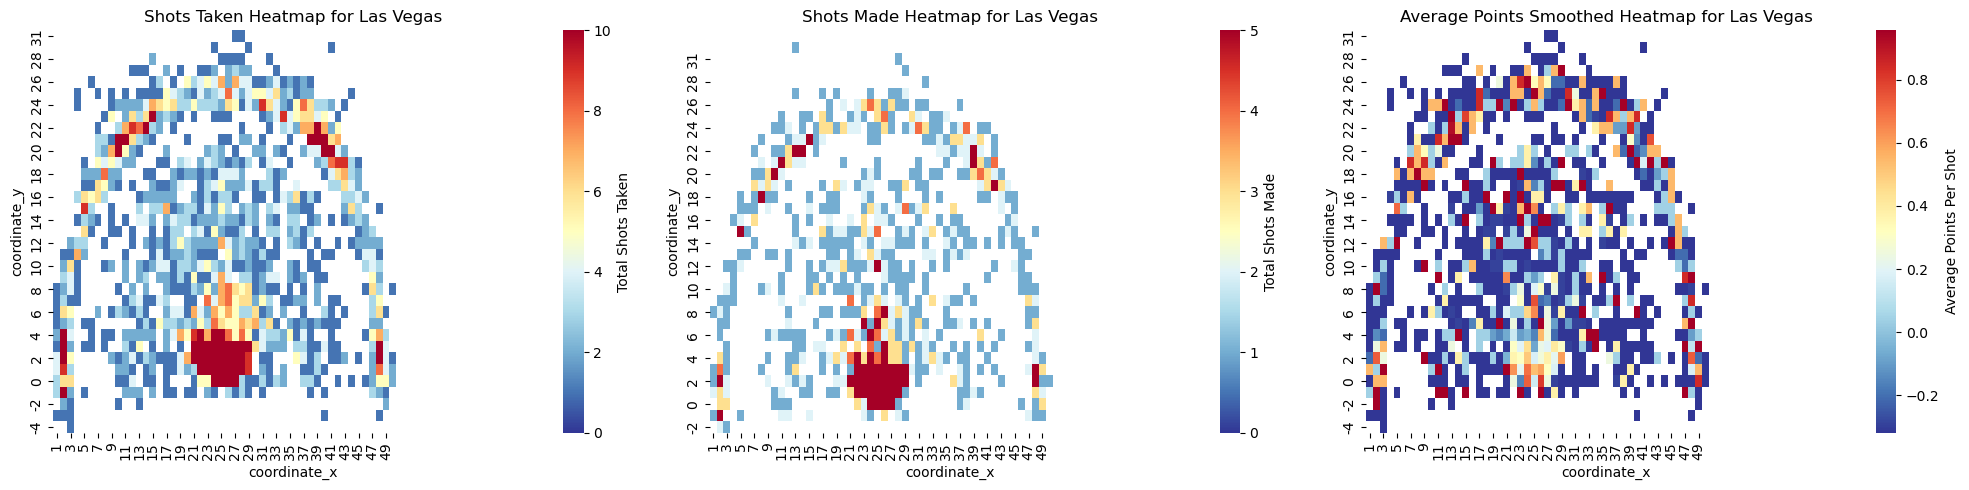

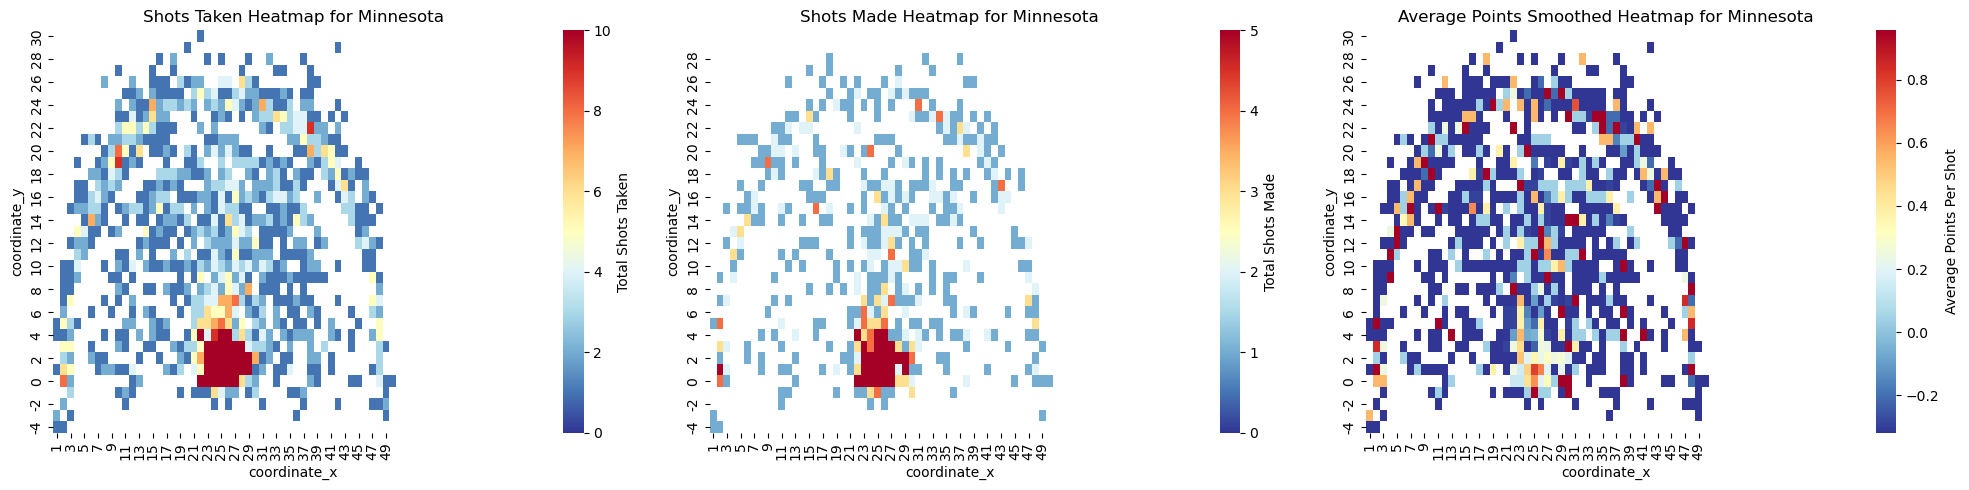

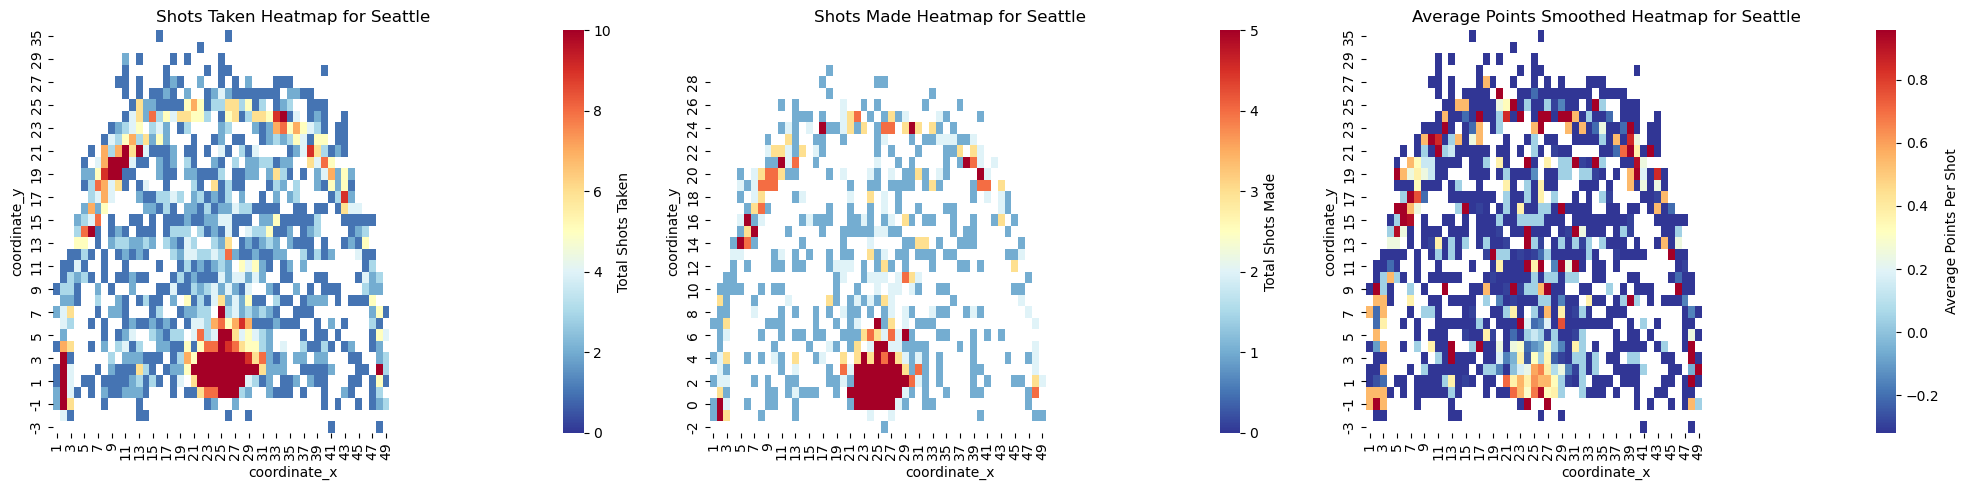

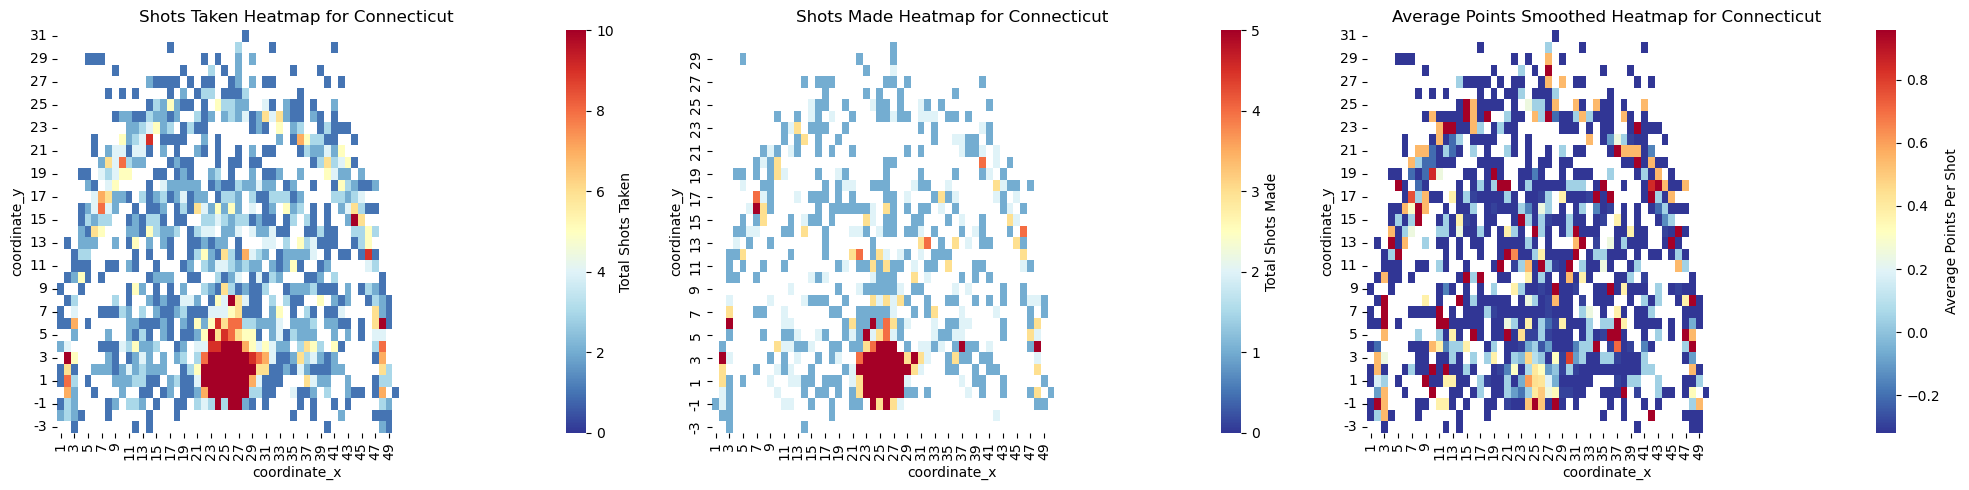

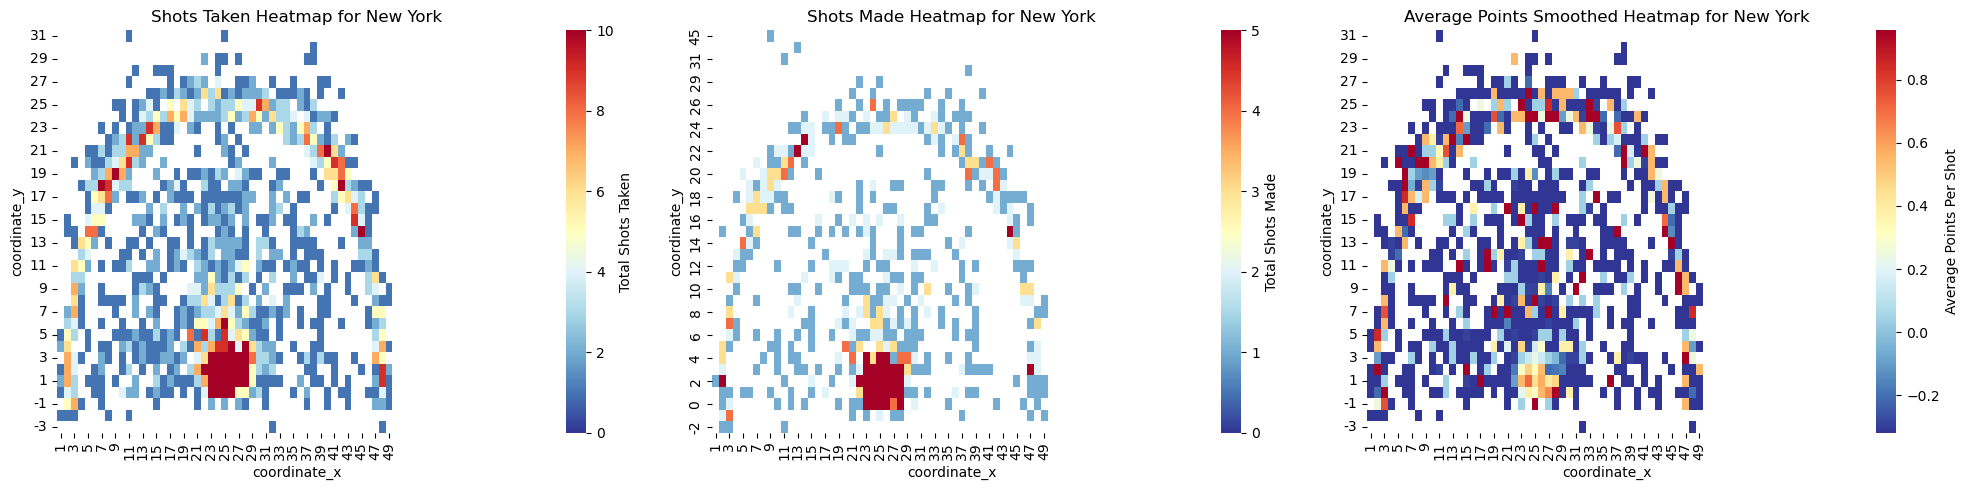

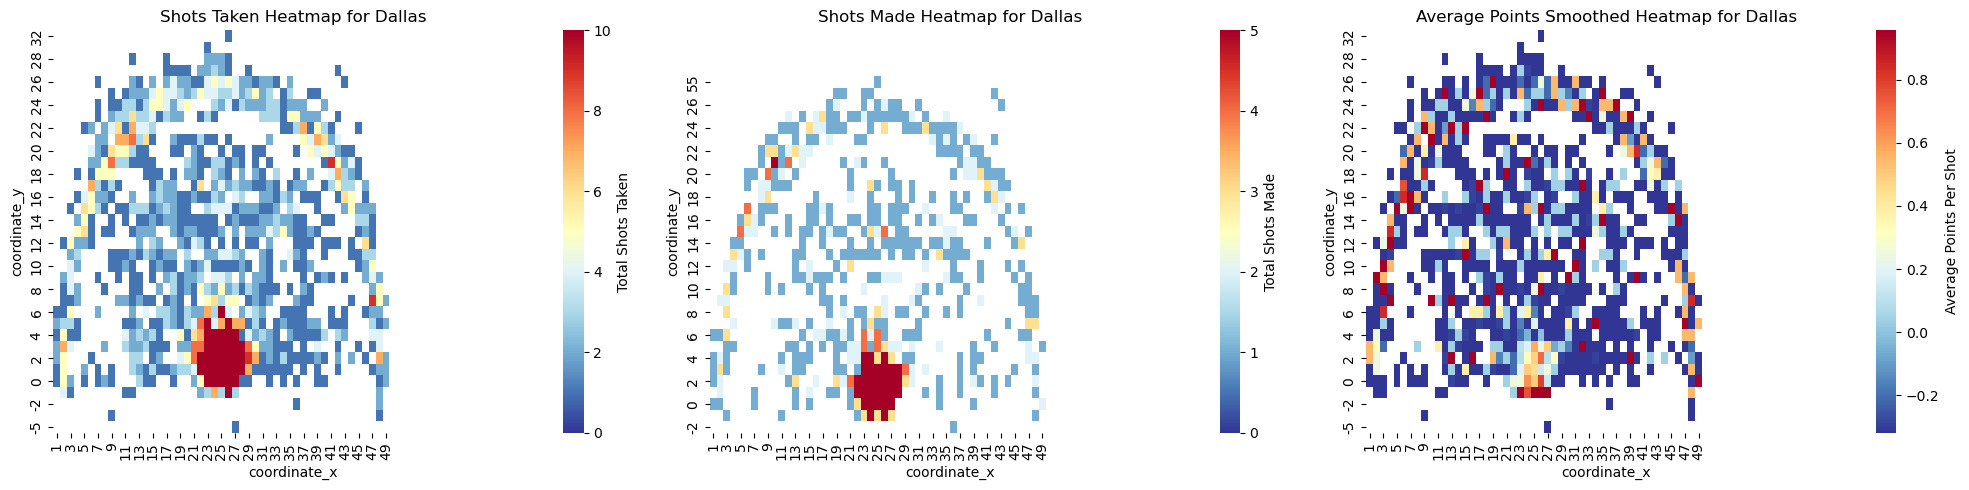

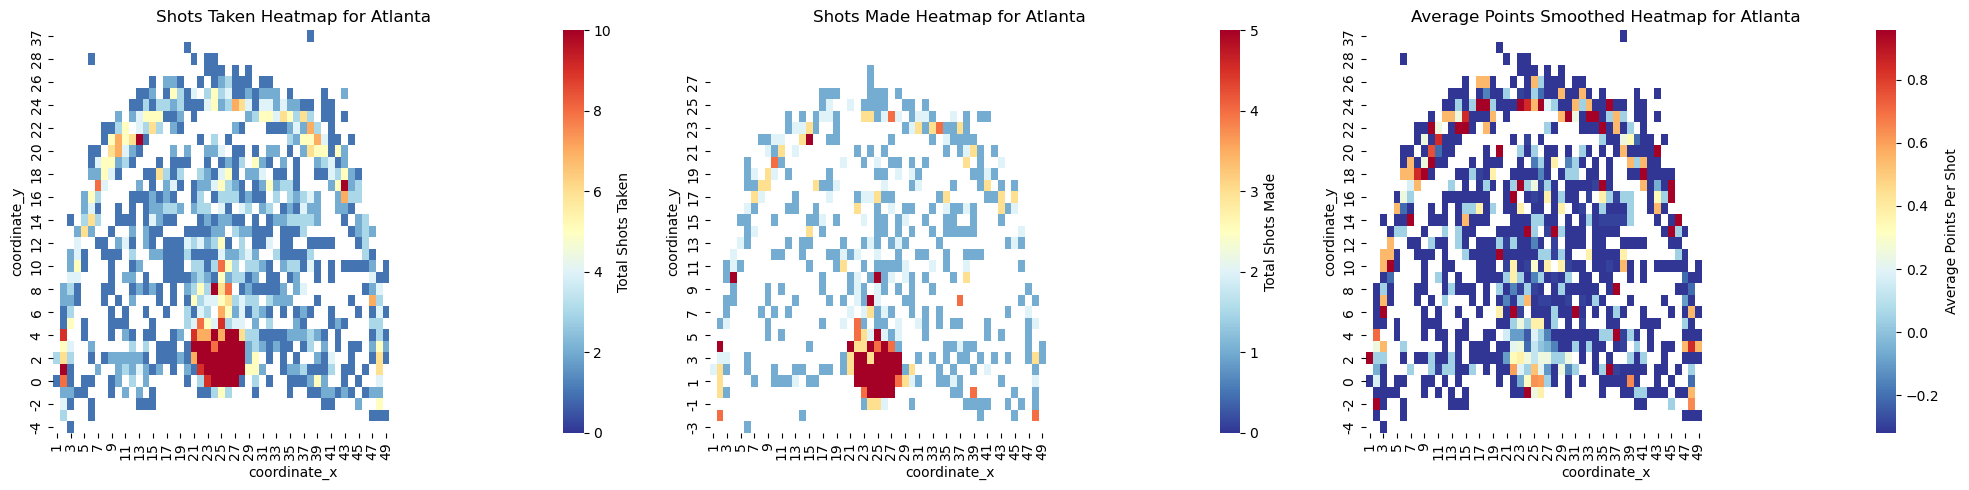

In [28]:
for n in df1['shooting_team'].unique():
    team_shots_gb = df1[(df1['shooting_team'] == n) &
                        (df1['max_value'] > 1)].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()
    
    team_shots_data = team_shots_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

    team_makes_gb = df1[(df1['shooting_team'] == n) &
                        (df1['max_value'] > 1) &
                        (df1['made_shot'] == True)].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()

    team_makes_data = team_makes_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

    # Setting Data up to get the expected points for each spot on the floor
    result_df = df1[df1['shooting_team'] == n].groupby(['coordinate_x', 'coordinate_y']).agg(
        total_made_shots=pd.NamedAgg(column='made_shot', aggfunc='sum'),
        total_shots=pd.NamedAgg(column='made_shot', aggfunc='count'),
        max_value=('max_value', 'first')
    ).reset_index()

    # Removing spots where there was only 1 shot taken, typically extremely long distance shots that end a quarter
    result_df.loc[result_df['total_shots'] <= 1, 'total_made_shots'] = 0

    # Calculating the average number of points earned for each spot on the floor
    result_df['result'] = (result_df['total_made_shots'] / result_df['total_shots']) * result_df['max_value']

    result_df['mean_compare'] = result_df['result'] - mean_value

    team_xp_data = result_df.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'mean_compare')

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot 1: Total Shots Taken Heatmap
    sns.heatmap(team_shots_data, cmap='RdYlBu_r', vmin=0, vmax=10, cbar_kws={'label': 'Total Shots Taken'}, ax=axes[0])
    axes[0].set_title(f'Shots Taken Heatmap for {n}')
    axes[0].set_xlim(0, 70)
    axes[0].set_ylim(0, 35)

    # Plot 2: Shots Made Heatmap
    sns.heatmap(team_makes_data, cmap='RdYlBu_r', vmin=0, vmax=5, cbar_kws={'label': 'Total Shots Made'}, ax=axes[1])
    axes[1].set_title(f'Shots Made Heatmap for {n}')
    axes[1].set_xlim(0, 70)
    axes[1].set_ylim(0, 35)

    # Plot 3: Average Points Smoothed Heatmap
    sns.heatmap(team_xp_data, cmap='RdYlBu_r', vmin=-mean_value/3, vmax=mean_value, cbar_kws={'label': 'Average Points Per Shot'}, ax=axes[2])
    axes[2].set_title(f'Average Points Smoothed Heatmap for {n}')
    axes[2].set_xlim(0, 70)
    axes[2].set_ylim(0, 35)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### 3. Perform a similar analysis by shot type

While there are some slight differences between teams, I would suspect that there would be many more differences between where types of shots are taken and how much value they have relative to the average shot.

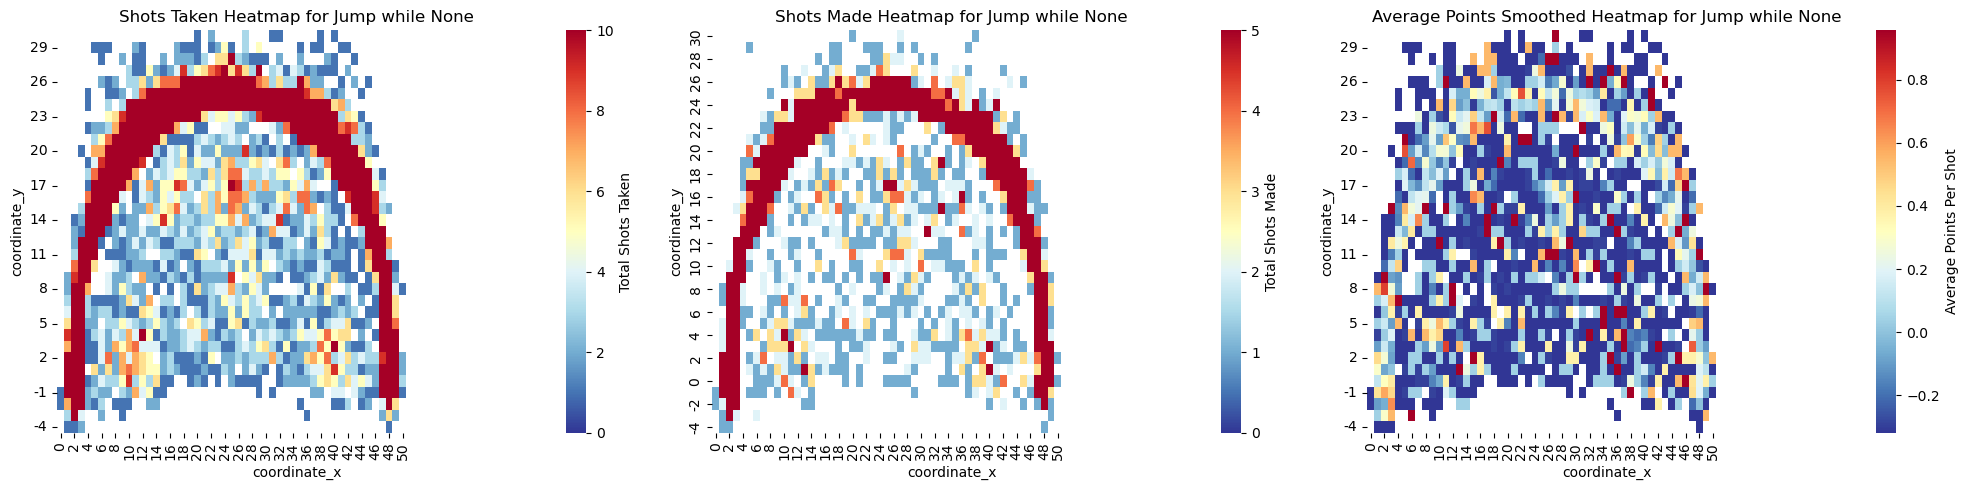

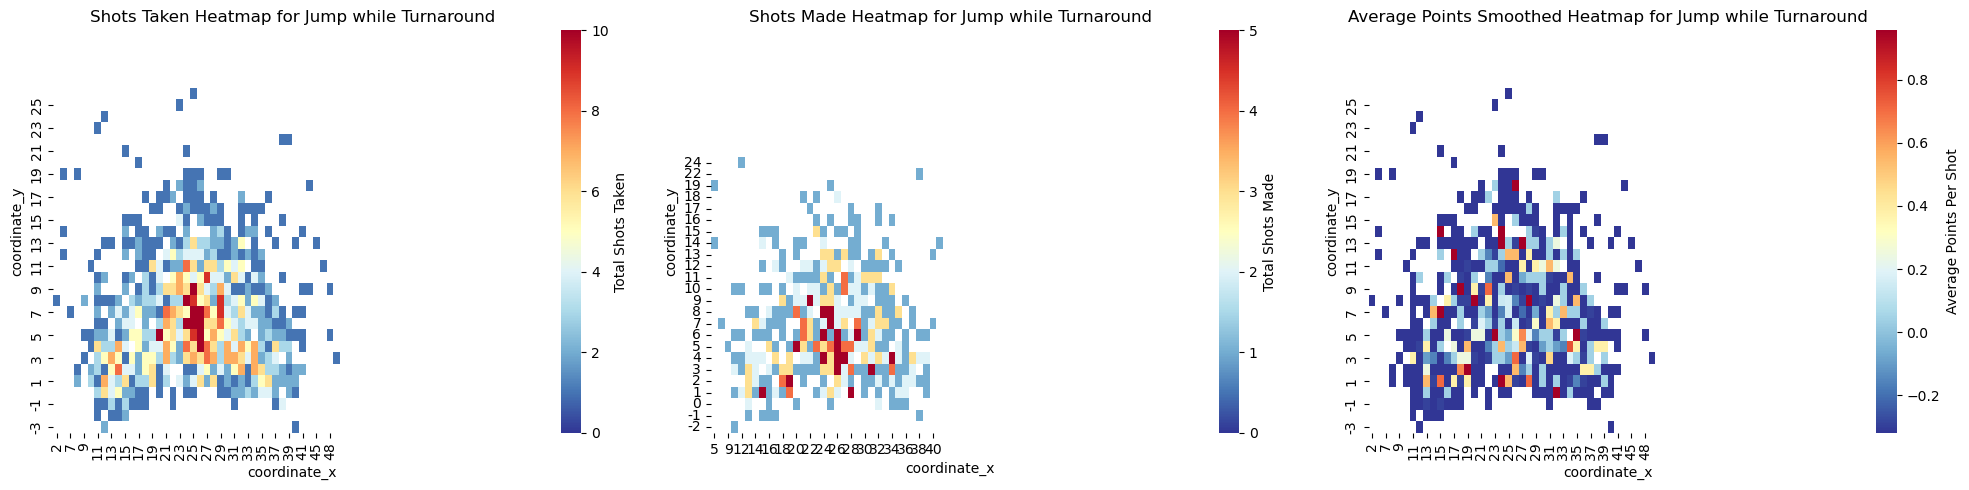

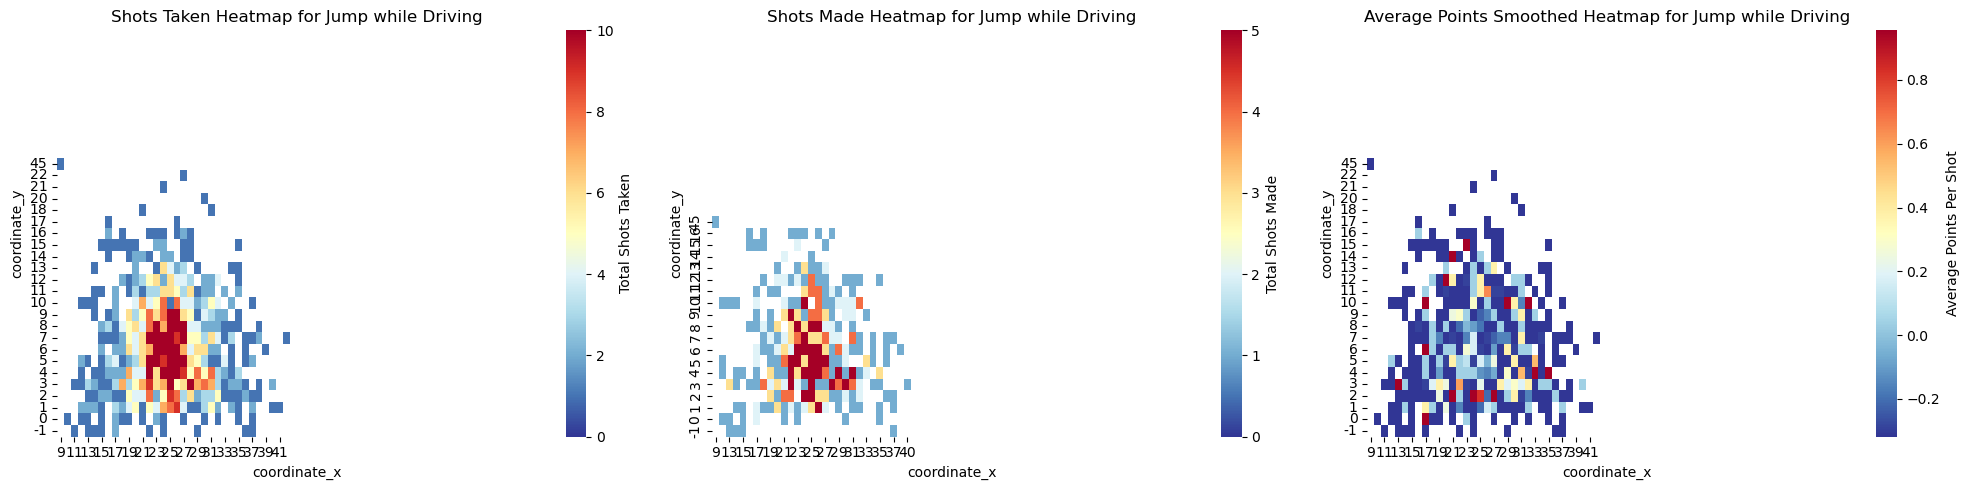

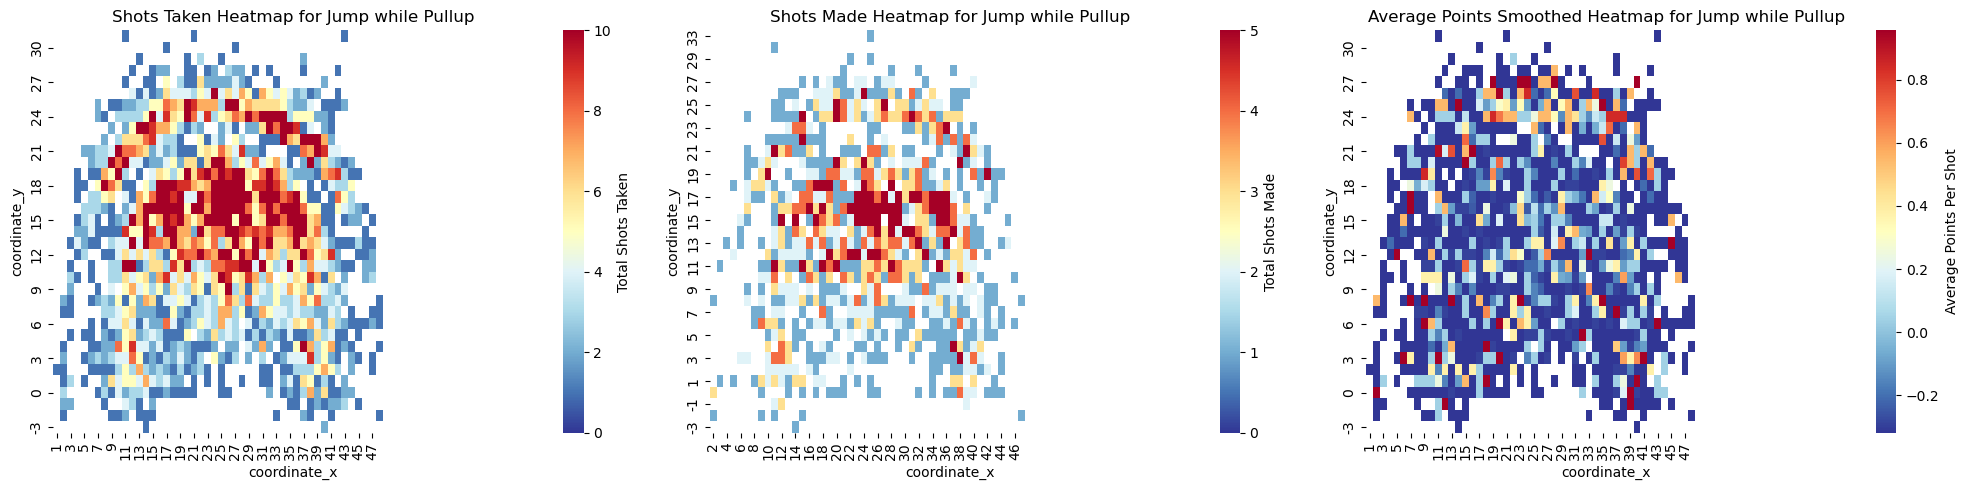

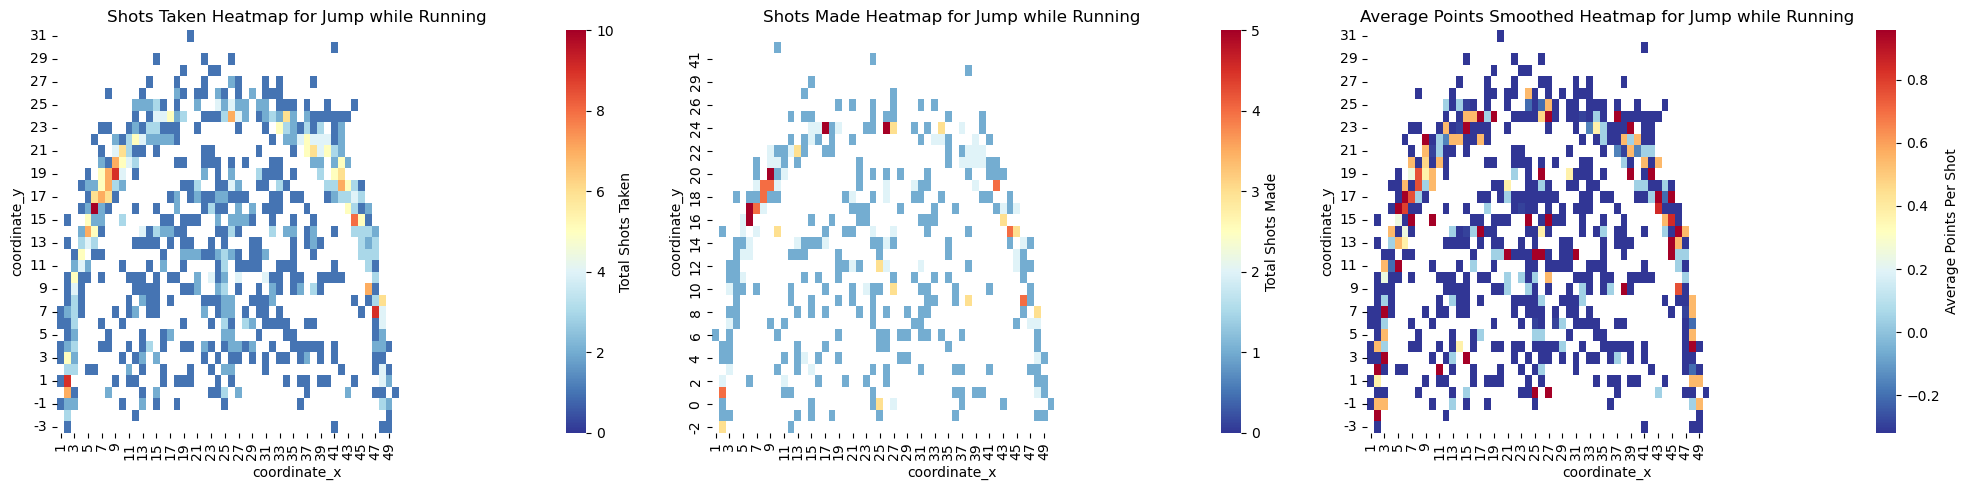

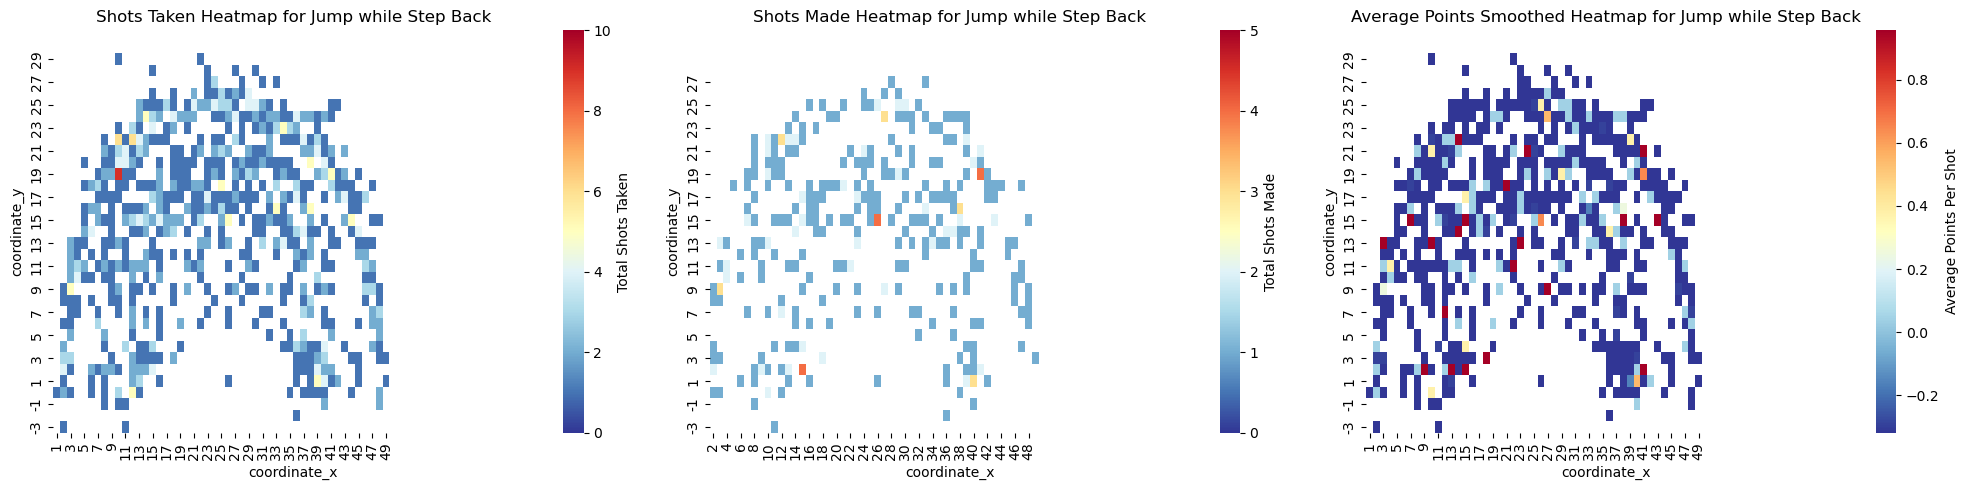

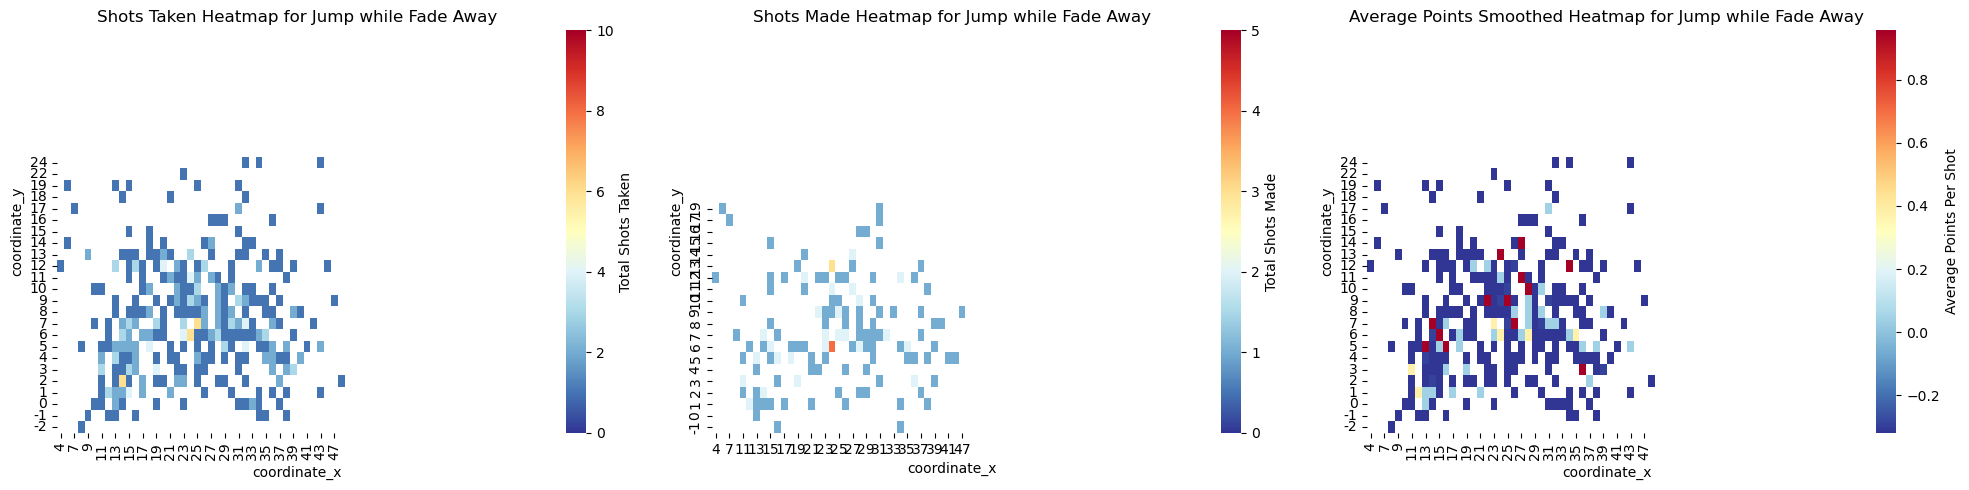

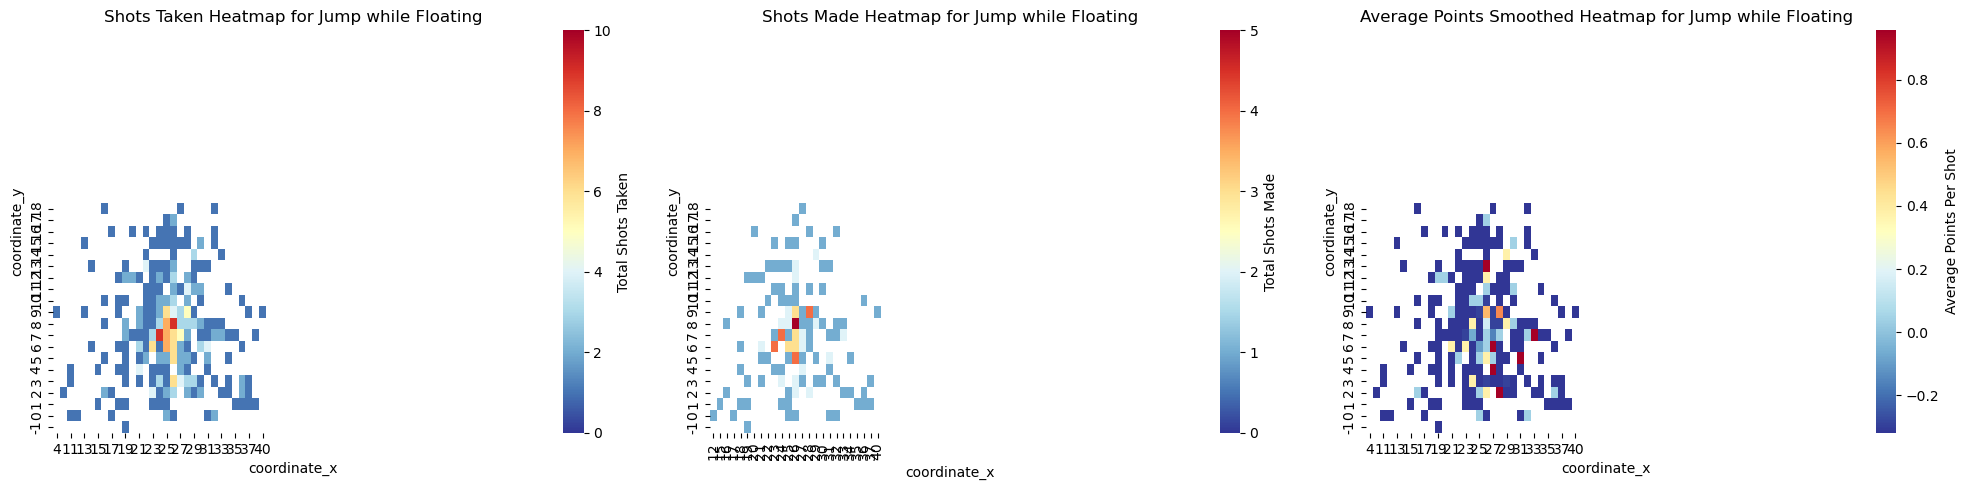

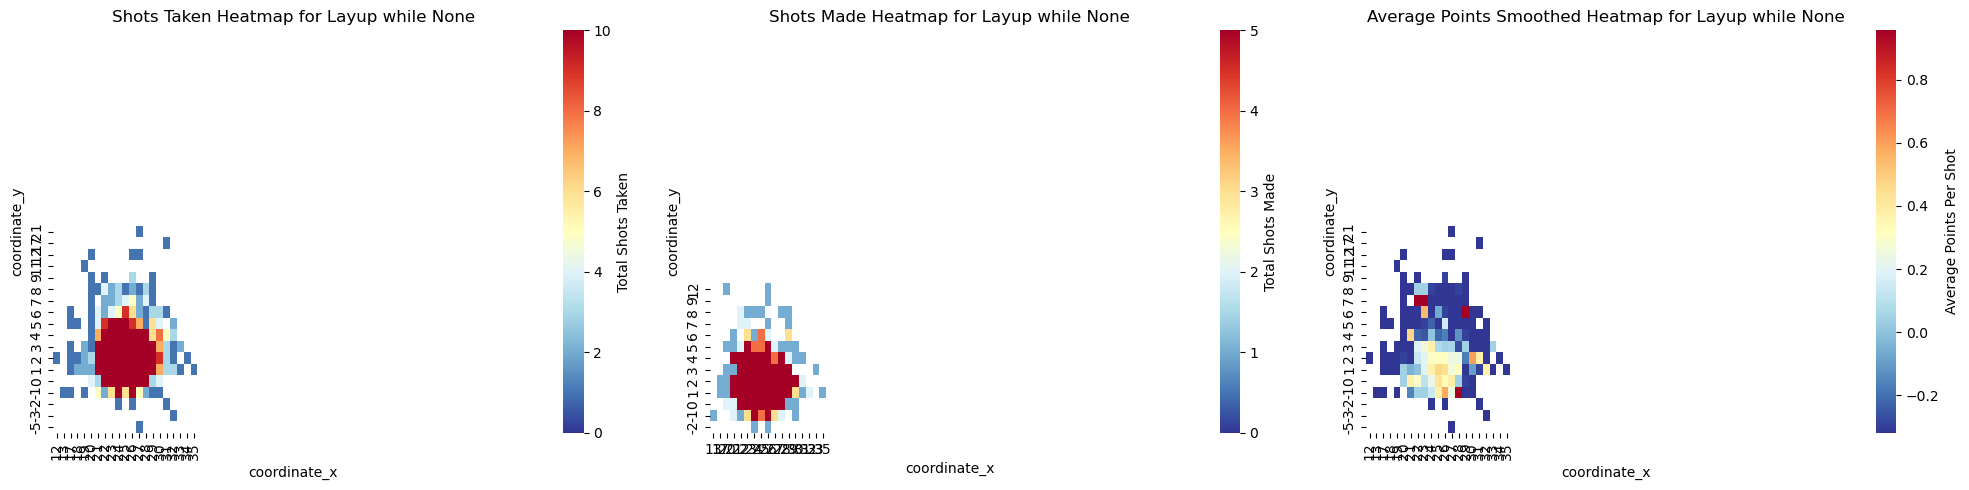

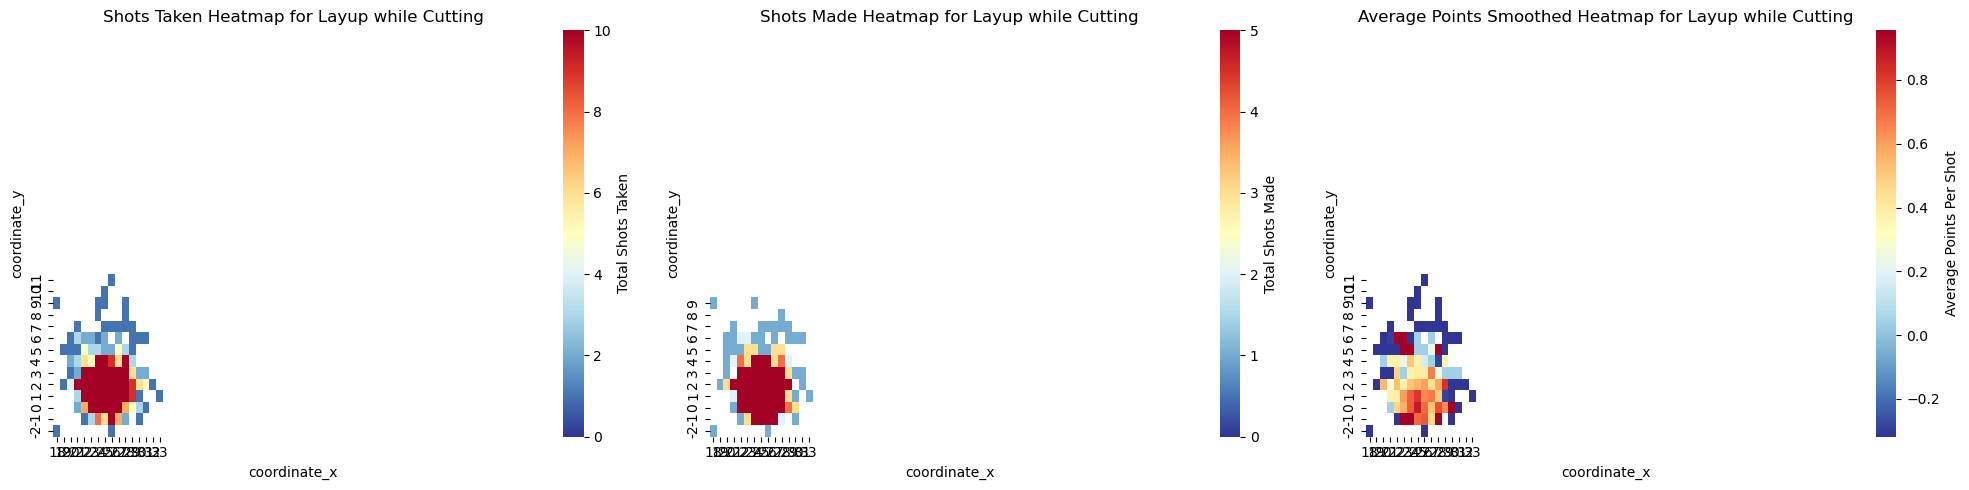

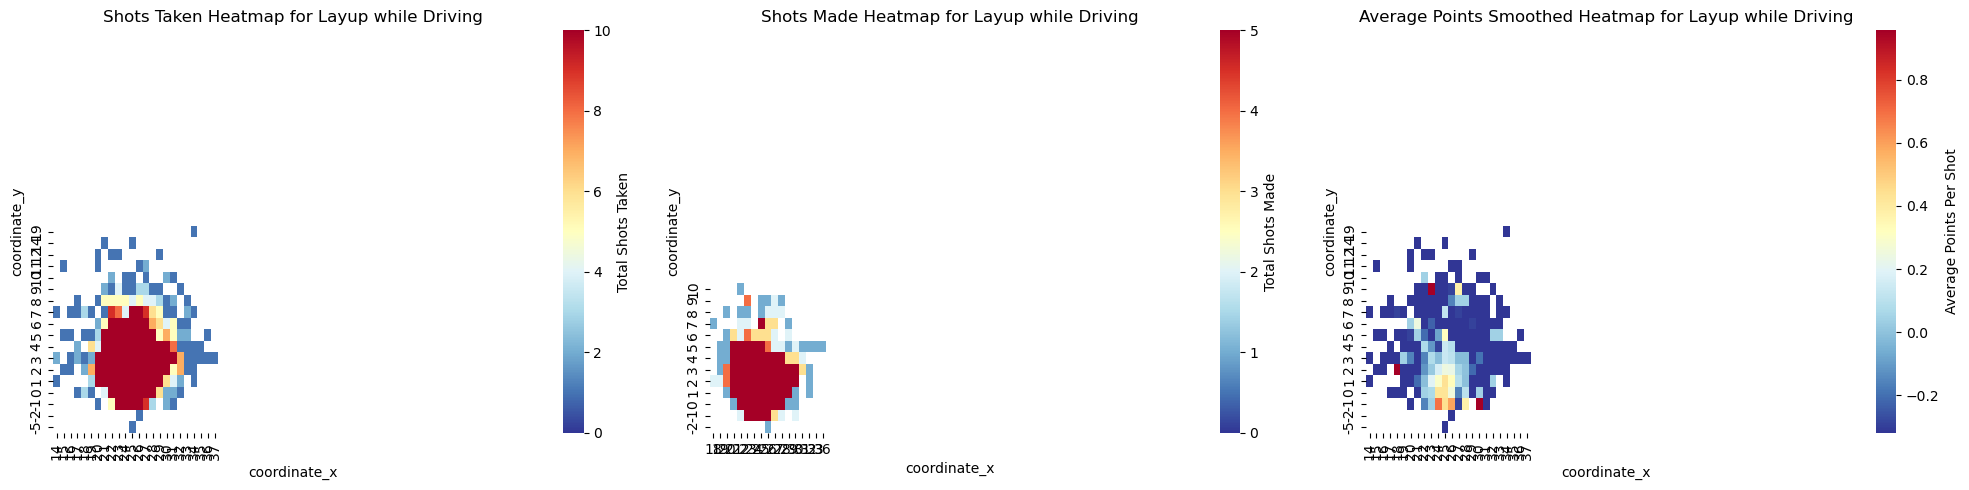

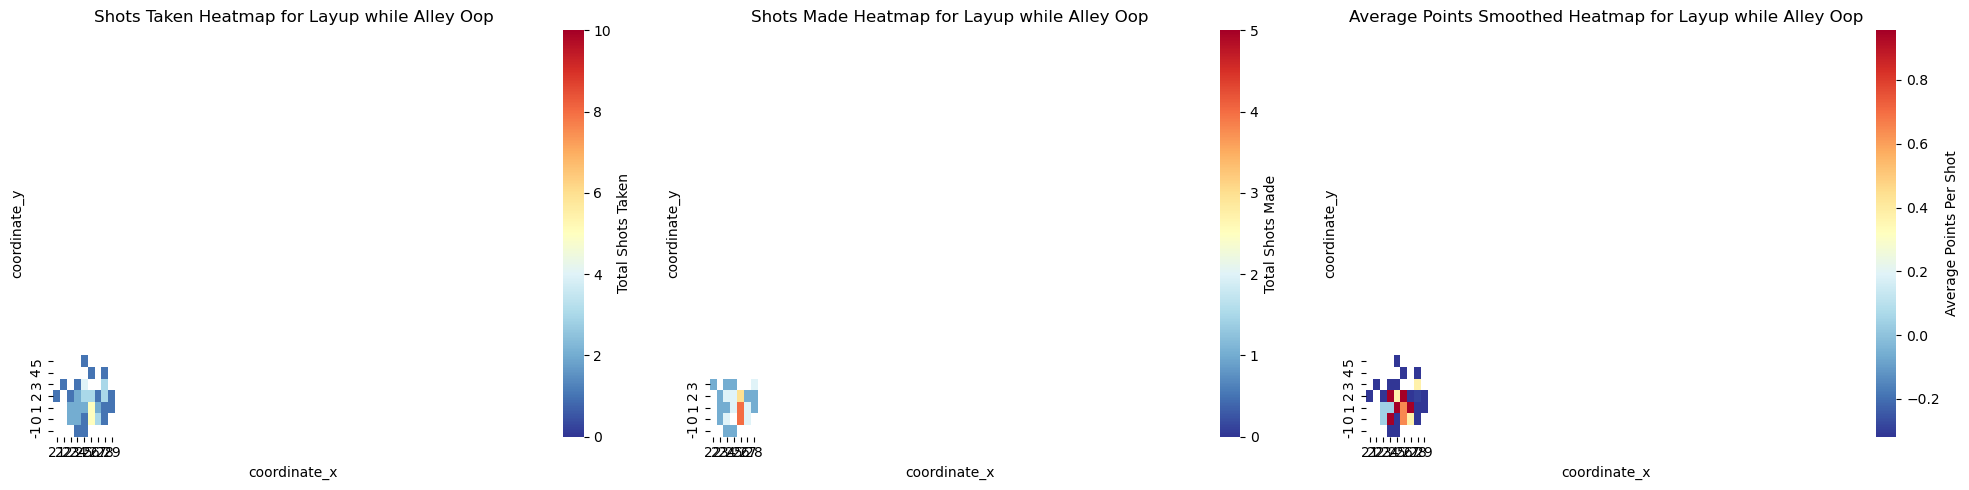

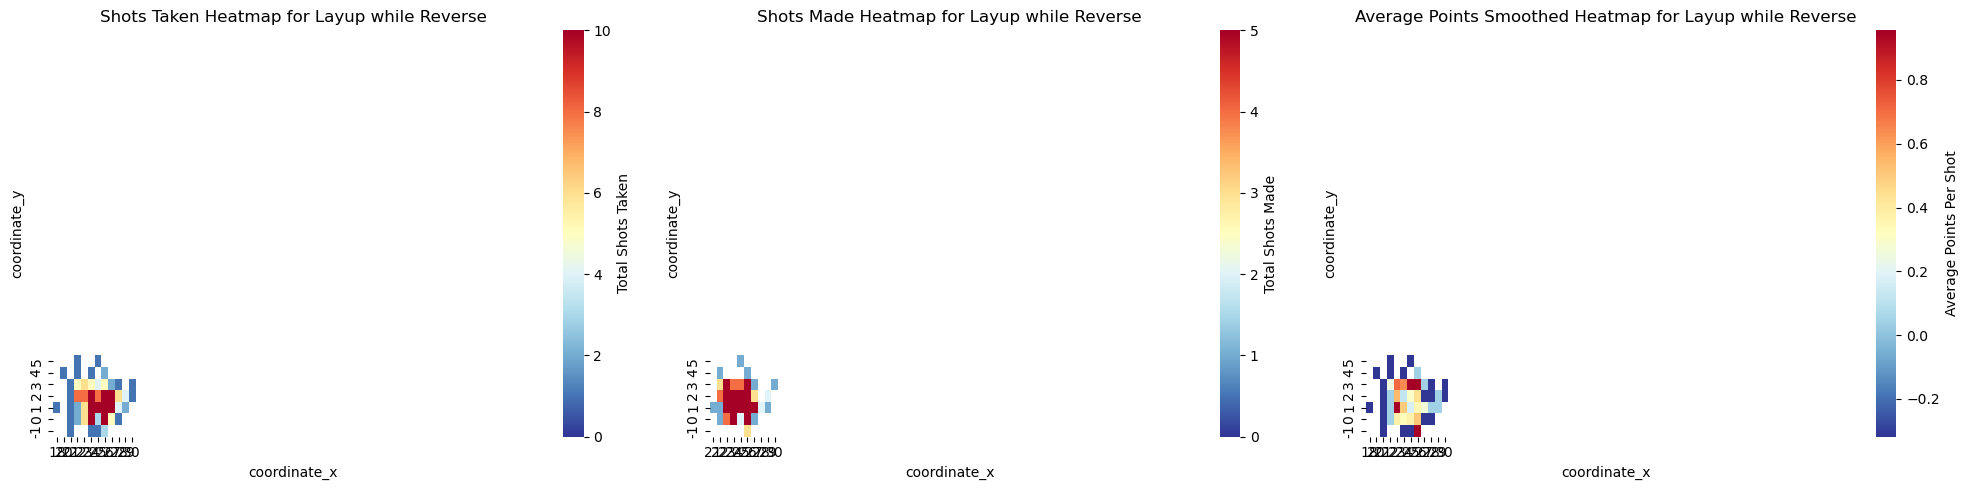

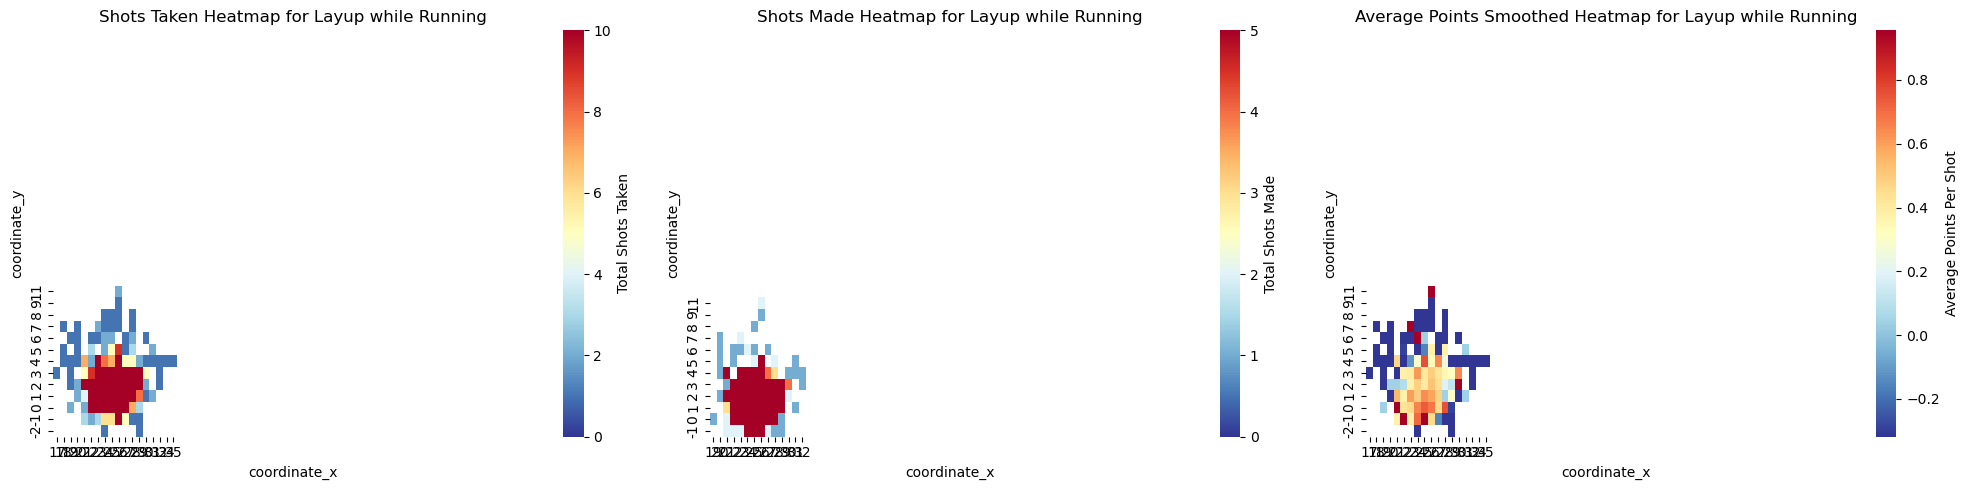

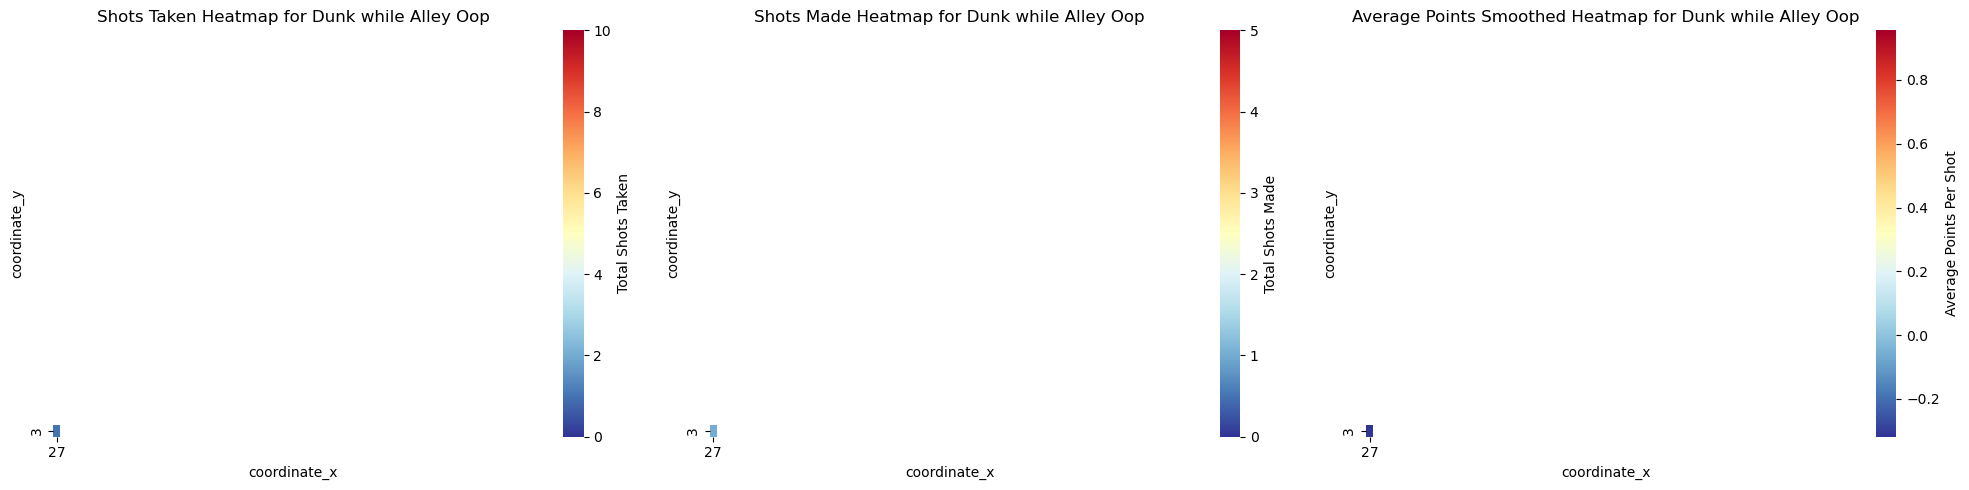

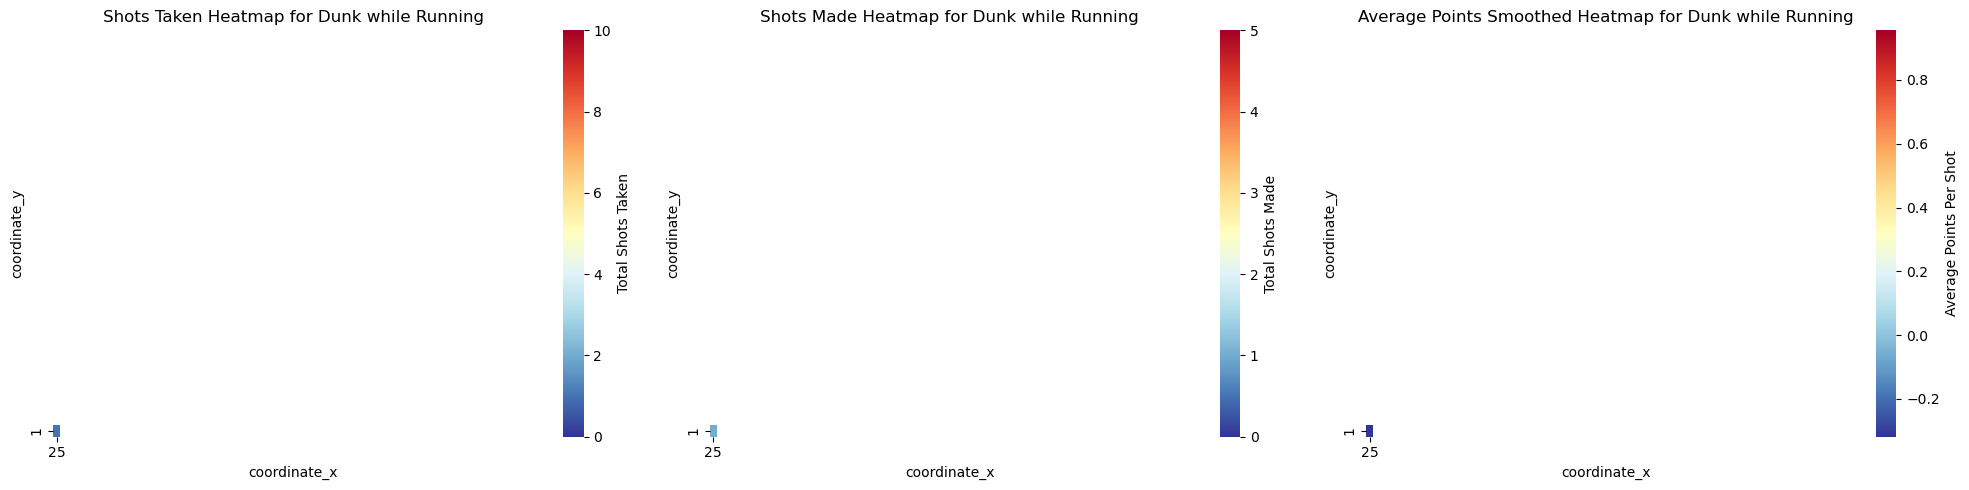

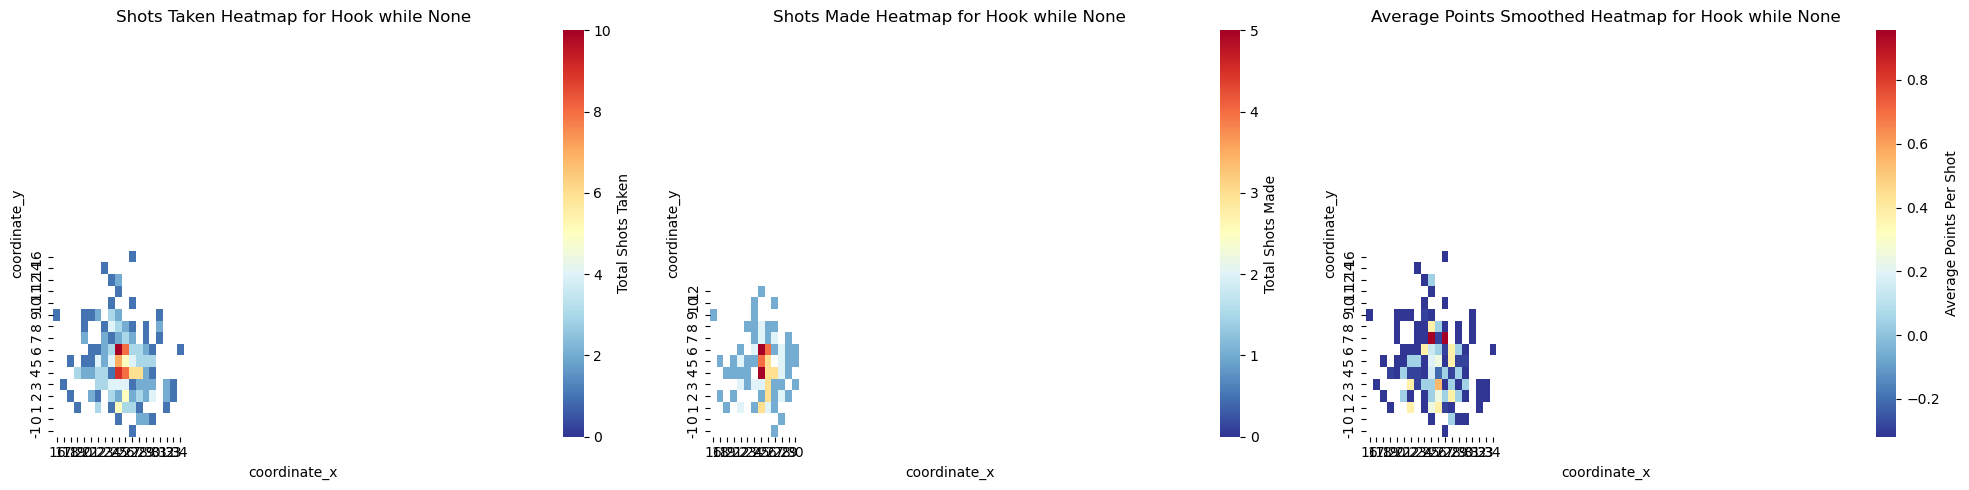

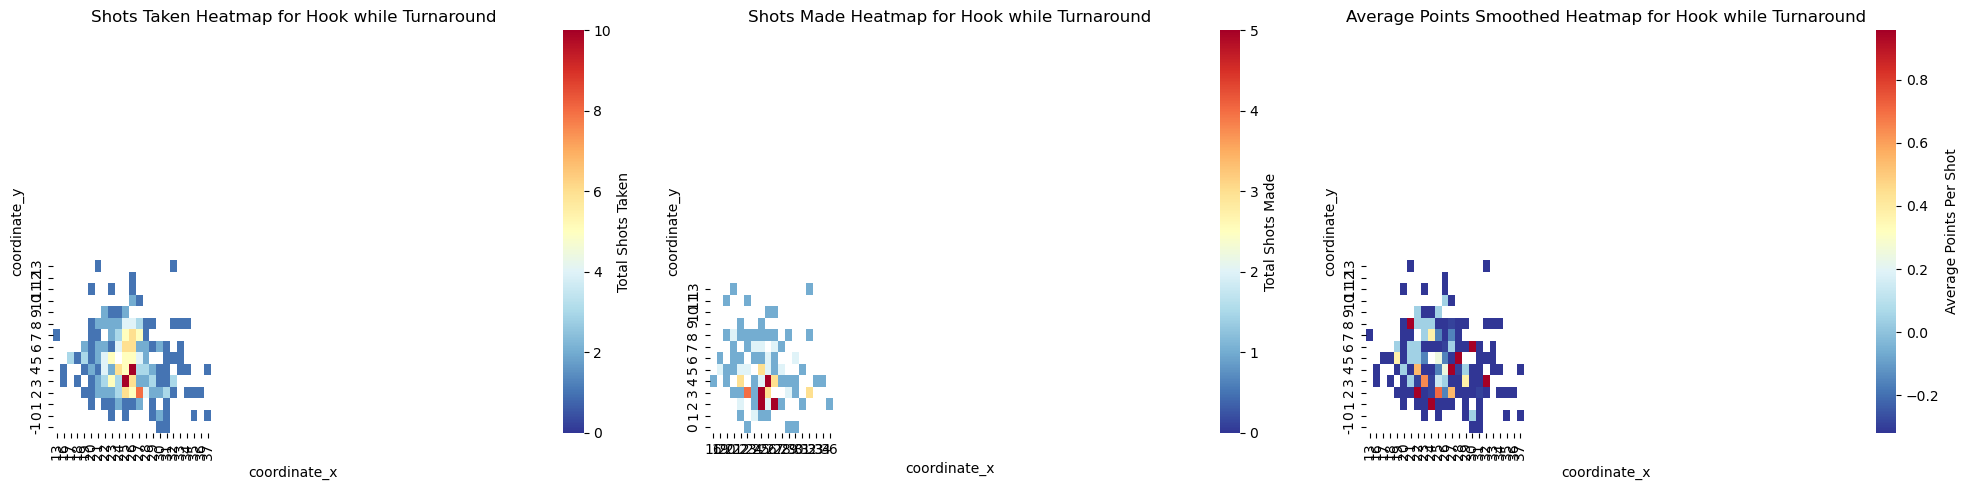

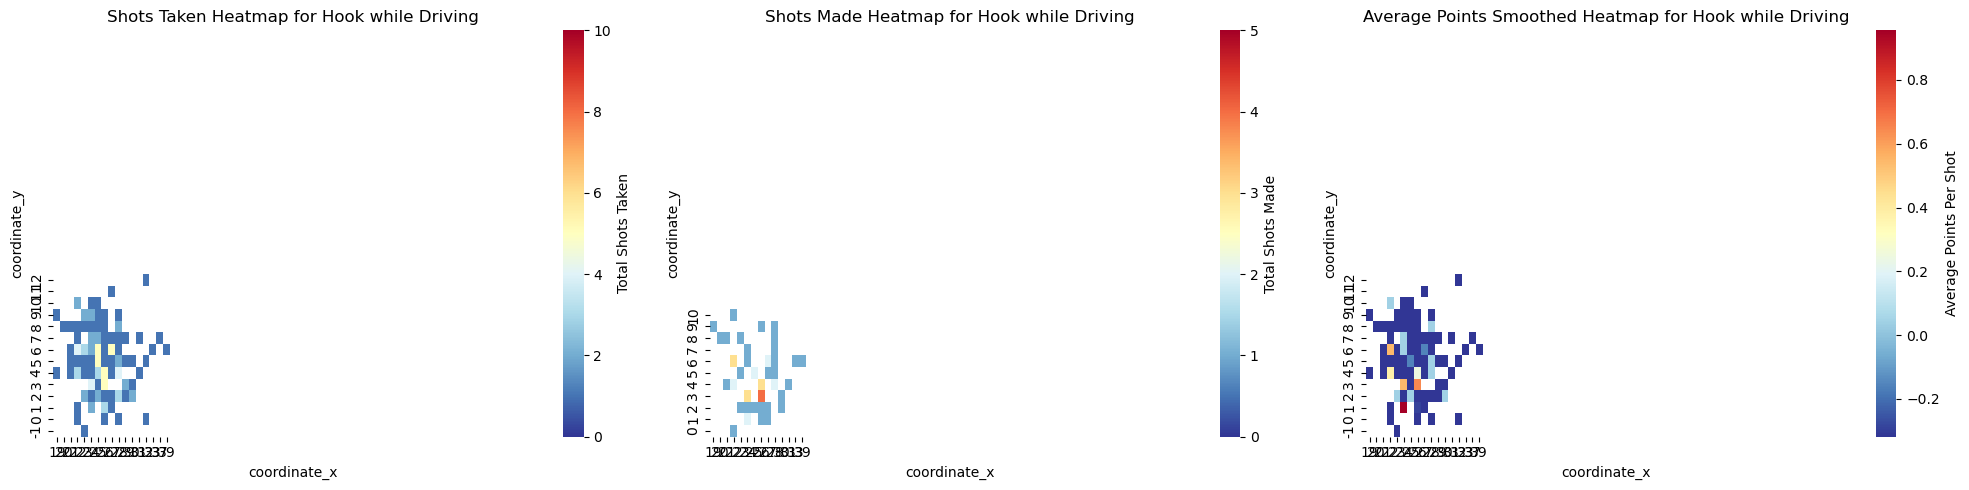

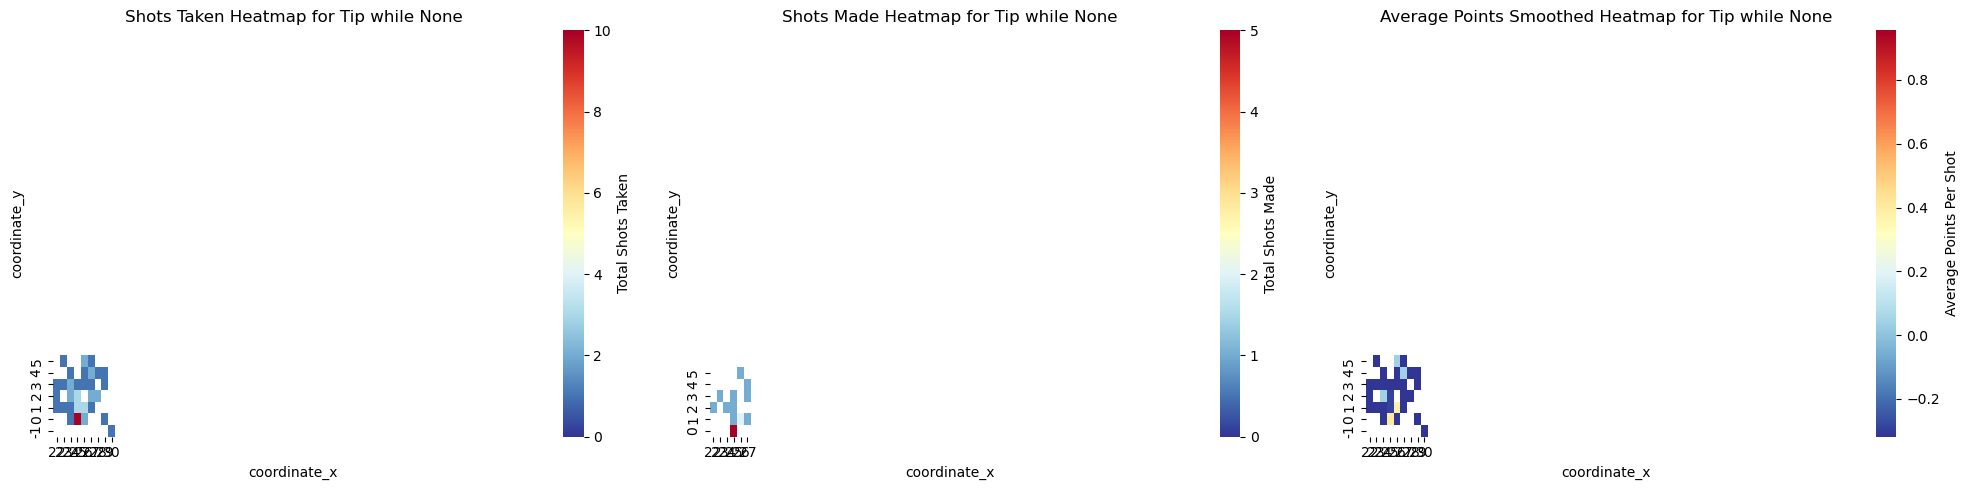

In [29]:
for shot in df1['type'].unique():
    for movement in df1['movement'].unique():
        if (len(df1[(df1['type'] == shot) & (df1['movement'] == movement)]) == 0) or (shot == 'Free Throw') or (shot == 'None'):
            pass
        else:
            team_shots_gb = df1[(df1['type'] == shot) &
                                (df1['movement'] == movement) &
                                (df1['max_value'] > 1)].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()

            team_shots_data = team_shots_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

            team_makes_gb = df1[(df1['type'] == shot) &
                                (df1['movement'] == movement) &
                                (df1['max_value'] > 1) &
                                (df1['made_shot'] == True)].groupby(['coordinate_y', 'coordinate_x'])['made_shot'].count().reset_index()

            team_makes_data = team_makes_gb.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'made_shot')

            # Setting Data up to get the expected points for each spot on the floor
            result_df = df1[(df1['type'] == shot) &
                            (df1['movement'] == movement)].groupby(['coordinate_x', 'coordinate_y']).agg(
                total_made_shots=pd.NamedAgg(column='made_shot', aggfunc='sum'),
                total_shots=pd.NamedAgg(column='made_shot', aggfunc='count'),
                max_value=('max_value', 'first')
            ).reset_index()

            # Removing spots where there was only 1 shot taken, typically extremely long distance shots that end a quarter
            result_df.loc[result_df['total_shots'] <= 1, 'total_made_shots'] = 0

            # Calculating the average number of points earned for each spot on the floor
            result_df['result'] = (result_df['total_made_shots'] / result_df['total_shots']) * result_df['max_value']

            result_df['mean_compare'] = result_df['result'] - mean_value

            team_xp_data = result_df.pivot(columns= 'coordinate_x', index = 'coordinate_y', values = 'mean_compare')

            fig, axes = plt.subplots(1, 3, figsize=(20, 5))

            # Plot 1: Total Shots Taken Heatmap
            sns.heatmap(team_shots_data, cmap='RdYlBu_r', vmin=0, vmax=10, cbar_kws={'label': 'Total Shots Taken'}, ax=axes[0])
            axes[0].set_title(f'Shots Taken Heatmap for {shot} while {movement}')
            axes[0].set_xlim(0, 70)
            axes[0].set_ylim(0, 35)
            

            # Plot 2: Shots Made Heatmap
            sns.heatmap(team_makes_data, cmap='RdYlBu_r', vmin=0, vmax=5, cbar_kws={'label': 'Total Shots Made'}, ax=axes[1])
            axes[1].set_title(f'Shots Made Heatmap for {shot} while {movement}')
            axes[1].set_xlim(0, 70)
            axes[1].set_ylim(0, 35)

            # Plot 3: Average Points Smoothed Heatmap
            sns.heatmap(team_xp_data, cmap='RdYlBu_r', vmin=-mean_value/3, vmax=mean_value, cbar_kws={'label': 'Average Points Per Shot'}, ax=axes[2])
            axes[2].set_title(f'Average Points Smoothed Heatmap for {shot} while {movement}')
            axes[2].set_xlim(0, 70)
            axes[2].set_ylim(0, 35)

            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

### 4. Build a classification model to predict the shot outcome based on the spatial x,y coordinates of the shot.
#### Logistic Regression

In preparation for modeling, `made_shot` will be my target variable, so I will change that to a numerical.

I will start with just seeing the total percentage of shots made, as well as a straight forward Logistic Regression using just the X and Y coordinates of the shot to determine it's outcome.  These will establish a baseline fior comparing future models.

In [30]:
print(f"The Percentage of Made Shots is {round(df1['made_shot'].mean(), 4)*100}%")

The Percentage of Made Shots is 51.580000000000005%


In [31]:
y = df1.loc[:, 'made_shot'].astype('int')
X = df1[['coordinate_x', 'coordinate_y']]

In [32]:
log_reg = LogisticRegression()
log_reg.fit(X, y)
print(f"The result of a simple Logistic Regression is {round(log_reg.score(X, y), 4)*100}")

The result of a simple Logistic Regression is 51.76


The overall average of shots made was 51.58% and the result of a Logistic Regression using just the x and y coordinates of the shots only improved it to 51.76%.  With that as the baseline, we'll see if we can improve the logistic regression using more of the dataset that we have available to us.

In [33]:
X = df1[['shooter_home', 'qtr', 'quarter_seconds_remaining', 'game_seconds_remaining', 'home_score',
    'away_score', 'score_diff', 'coordinate_x', 'coordinate_y', 'max_value', 'shot_dist']]

In [34]:
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X, y)
log_reg.score(X, y)

0.6194767441860465

Including numerical data about each shot significantly increased the accuracy of the model.  However, there is a bit to do in to make sure that there is limited multi-collinearity and simplicity.  Here is what I will do:

1. Get dummies for categorical data (shot `style`, `type` and `movement`)
2. Remove features that have shown multi-collinearity.  Namely `max_value` of the shot, `qtr` (keeping the `game_seconds_remaining`, `shot_dist` (keeping the x and y coordinates instead), `home_score` and `away_score` (these were too associated with the `game_seconds_remaining`)
3. Scale the numerical data

In [35]:
df2 = df1.loc[:,'shooter_home':]

In [36]:
df3 = pd.get_dummies(df2.loc[df2['max_value'] != 1]).drop(columns = ['style_None',
                                                                         'type_None',
                                                                         'movement_None',
                                                                         'shot_value']).reset_index()

In [37]:
# Removing columns that showed multi-collinearity with other features
df4 = df3.drop(columns = ['max_value', 'qtr', 'shot_dist', 'home_score', 'away_score'])

In [38]:
categorical_df = pd.concat([df4.loc[:, 'movement_Alley Oop':], df4['shooter_home']], axis = 1)

In [39]:
numerical_df = df4[['quarter_seconds_remaining',
                    'game_seconds_remaining',
                    'coordinate_x',
                    'coordinate_y'
                   ]]

In [40]:
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical_df)
numerical_scaled_df = pd.DataFrame(data = numerical_scaled, columns = numerical_df.columns)

In [41]:
scaled_df = pd.concat([categorical_df, numerical_scaled_df], axis = 1)

In [42]:
X = scaled_df
y = df4['made_shot']

In [43]:
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X, y)
log_reg.score(X, y)

0.6259682209227566

With all of these changes, we have improved the model by nearly 1%, but also decreased the amount of potential multi-collinearity which will lead to a more effective model going forward.

In [44]:
pd.DataFrame(columns = X.columns, data = log_reg.coef_).T.sort_values(0).rename(columns={0: 'coefs'})

,coefs
coordinate_y,-1.503863
type_Jump,-0.379450
type_Hook,-0.303467
movement_Driving,-0.264269
movement_Fade Away,-0.060634
coordinate_x,-0.010521
movement_Pullup,-0.006247
shooter_home,-0.005832
movement_Step Back,-0.001393
movement_Turnaround,0.039745


<Axes: >

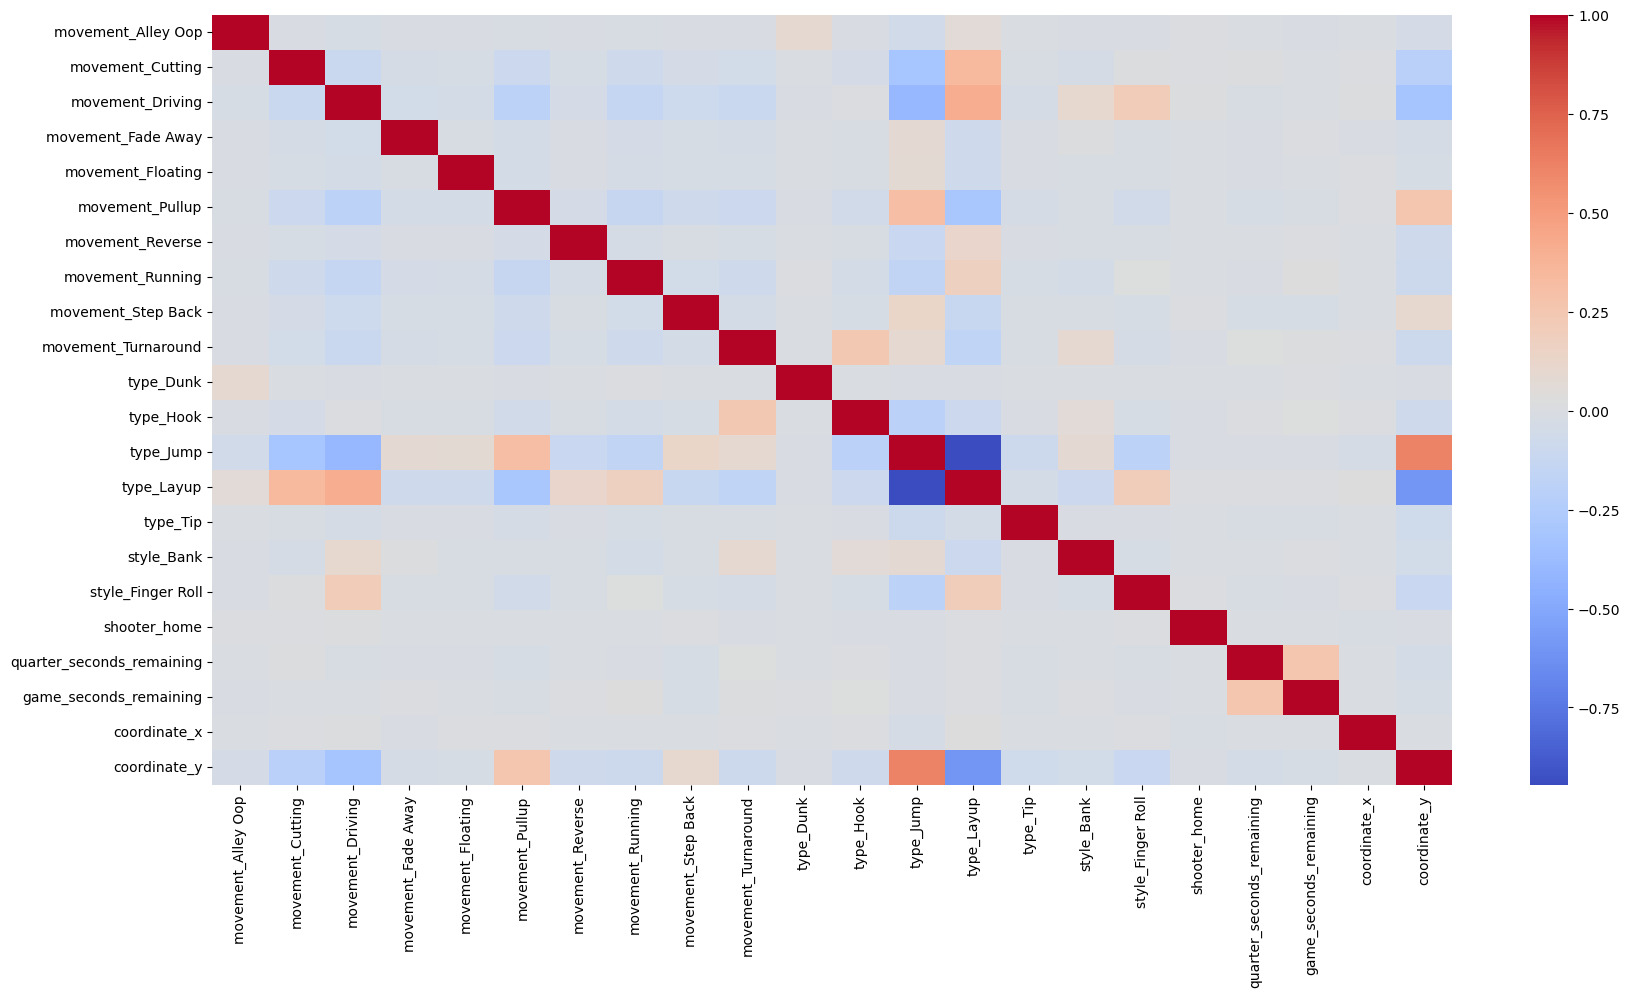

In [45]:
plt.figure(figsize = (20,10))
sns.heatmap(scaled_df.corr(), cmap = 'coolwarm')

In [46]:
pd.concat([X, y], axis=1).corr()['made_shot'].sort_values()

type_Jump                   -0.202759
coordinate_y                -0.175714
movement_Pullup             -0.073883
movement_Step Back          -0.030780
movement_Fade Away          -0.014550
movement_Turnaround         -0.012105
type_Hook                   -0.006467
movement_Floating           -0.004801
shooter_home                 0.000580
coordinate_x                 0.003861
type_Dunk                    0.008777
type_Tip                     0.016477
movement_Alley Oop           0.017232
game_seconds_remaining       0.017784
quarter_seconds_remaining    0.024913
movement_Reverse             0.026497
movement_Driving             0.028297
style_Bank                   0.029191
style_Finger Roll            0.062668
movement_Running             0.087479
movement_Cutting             0.143641
type_Layup                   0.205911
made_shot                    1.000000
Name: made_shot, dtype: float64

With a better sense of the data now, I will do a more proper training split in order to optimize the logistic regression model.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

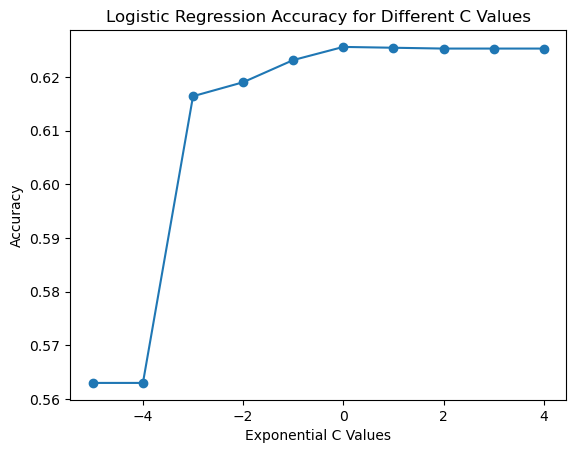

In [48]:
C_values = list(range(-5,5))
accuracy_scores = []

for C in C_values:
    model = LogisticRegression(C=10**C, random_state=42, max_iter = 1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Plot the results
plt.plot(C_values, accuracy_scores, marker='o')
plt.xlabel('Exponential C Values')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy for Different C Values')
plt.show()

In [49]:
log_reg = LogisticRegression(C=1, random_state=42, max_iter = 1000)
log_reg.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.625287004439002

In the end, the base Logistic Regression model on the scaled data provided the best accuracy, and is also the simplest.

From here, I would like to use this as an opportunity to use an Ensemble method is order to strengthen the predictions of the model.  With a Logistic Regression model completed, I would like to optimize the following models individually that use probability in order to determine the predictions:

1. SVM
2. Random Forest
3. XGBoost

From there, I will take the best performing version of each individual model, and use an Ensemble method using 'soft' voting to utilize the probability each model uses, to see if it will strengthen the predictions of the individual models.

#### SVM

In [50]:
svc = SVC(probability=True, random_state=42)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
accuracy_score(y_test, svc_preds)

0.6240624521659268

In [51]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [52]:
best_svc_preds = best_model.predict(X_test)
accuracy_score(y_test, best_svc_preds)

0.626817694780346

The best SVM model improved the accuracy by about 1%.  We'll see if we have better luck with Random Forest models.

#### Random Forest

In [53]:
param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

In [54]:
best_rf_params

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 150}

In [55]:
best_rf_preds = best_rf_model.predict(X_test)
accuracy_score(y_test, best_rf_preds)

0.6347772845553344

This was only a marignal improvement again, but still the highest performing model so far.  Next is XGBoost

#### XGBoost

In [56]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [25, 50, 75, 100],
}

grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xg_params = grid_search.best_params_
best_xg_model = grid_search.best_estimator_

In [57]:
best_xg_params

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}

In [58]:
best_xg_preds = best_xg_model.predict(X_test)
accuracy_score(y_test, best_xg_preds)

0.635389560691872

Again a marginal improvement, 0.1% this time.  Now I will try to put these together into an ensemble to see if I can improve the model.

I'm using a 'soft' voting for this ensemble.  I'm also giving equal weighting to each model as they all performed relatively equally.  This means that each model will have a percentage associated with the prediction.  Each of the percentages will be averaged out.  If the average of the percentages is greater than 50%, then that will be considered a 'yes' for `made_shot`.

#### Ensemble of Best Models

In [59]:
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42)),
    ('svc', SVC(probability = True, random_state=42, C = 10, gamma = 1)),
    ('rf', RandomForestClassifier(random_state=42, max_depth = 10, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 200)),
    ('xg', xgb.XGBClassifier(random_state=42, learning_rate = 0.2, max_depth = 3, n_estimators = 50))
], voting='soft')

In [60]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc',
                              SVC(C=10, gamma=1, probability=True,
                                  random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_by...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [61]:
ensemble_preds = ensemble_model.predict(X_test)
accuracy_score(y_test, ensemble_preds)

0.636154905862544

#### Model Evaluation

In [62]:
y_prob = ensemble_model.predict_proba(X_test)[:, 1]

In [63]:
precision = precision_score(y_test, ensemble_preds)
recall = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
logloss = log_loss(y_test, y_prob)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Log Loss: {logloss}")

Precision: 0.6265889830508474
Recall: 0.41436077057793347
F1-Score: 0.4988403963736032
Log Loss: 0.6489168180225868


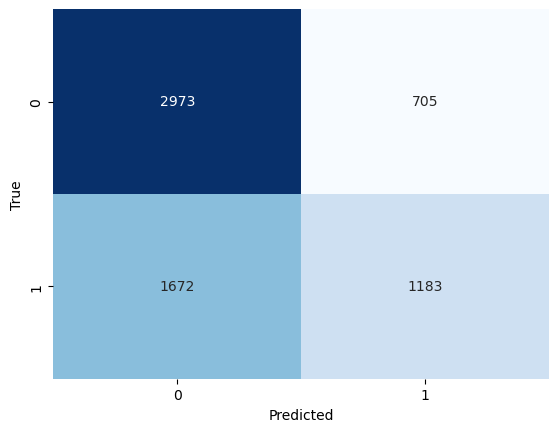

In [64]:
cm = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

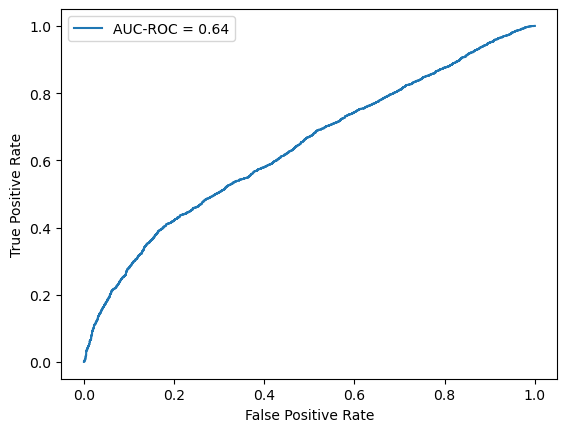

In [65]:
auc_roc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Model Summary

Overall, this model was an improvement on just guessing that a shot was made.  However, there is still room for further improvement in the model.
- The model underguessed the number of made shots, which raised the model's Precision score but guessing that many made shots were actually not made
- The logloss was .64, which suggests that the model had trouble predicting made shots and instead 'defaulted' to the shot not being made and required a lot of input from the features in order to move from that default state.
- The AUC was 0.64, which shows some benefit to the model but leaves a lot to be desired in overall performance.

From 51% of the shots being made, being able to predict that 63% of the shots accurately is a significant improvement.  Given the nature of the sport of basketball, where players are never 'perfect' in one spot, it is not surprising that the best model could not approach closer to 100%.

Moving forward from this model, areas to improve could be to use a neural network in order to increase the predictive power, but the more simple insights here might be the most powerful:
- Getting close to the basket and the 3-point line are the most beneficial
- Trying to get baskets on the move (cutting and running) helps increase shot percentage
- Pull-up shots are easy to get, but are not an efficient method of scoring compared to other shot types

All of these points are supportive of the direction that modern basketball has gone on offence.  Conversely, it is most vital for defences to adjust their game plans in order to minimize these higher percentage shots, 